感谢大家来我的网站学习https://www.captainbed.net

In [44]:
import numpy as np
import matplotlib.pyplot as plt 
import sklearn # 其它库之前我们都介绍过了。这个新库是用于数据挖掘，数据分析和机器学习的库，例如它里面就内置了很多人工智能函数
import sklearn.datasets
import sklearn.linear_model

# 下面两个库是我们自定义的，第一个提供一些工具函数，第二个提供一些单元测试工具函数。
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets 
from testCases import * 

%matplotlib inline

np.random.seed(1) # 设置一个随机数种子，来保证后面我的代码产生的随机数与你们电脑上产生的一样,这样我的结果才能和你们运行的结果一样

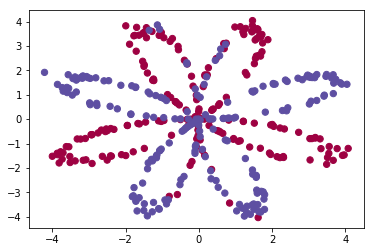

In [45]:
# 加载训练数据。这一次我们没有用真实的数据集，而是在planar_utils文件中用代码生成了一些虚拟的数据集。
# 这个数据集由400个样本组成。这400个样本是400个颜色点。输入特征X是点的横纵坐标，标签Y是点的颜色标签（0表示红色，1表示蓝色）
# 下面的图片展示了这400个颜色点。
# 我们的目标就是通过训练一个神经网络来通过坐标值判断在下图坐标系中某一点可能的颜色，
# 例如坐标（-4，2）的点可能是什么颜色，（-4，3）最可能是什么颜色。将红色和蓝色的点区分出来。
# 这好像没有上次我们编写的程序有实际意义——上次我们从图片中根据像素颜色值判断是否有猫。
# 但是我们的目的在于教学，所以不要太究竟实际用途，如果你能一路跟我走下去，是真爱粉，我后面会带你做实际项目的。
# 有些同学可能会到planar_utils文件中去看load_planar_dataset的实现。
# 如果你很了解python编程，你能看得懂里面的具体算法实现的话，你可以进去看。
# 对于一般同学，我觉得可以先不进去看，因为里面比较复杂，而且当前我们的重点是学习人工智能知识，而不是那些python编程。
# 在遇到每一个这样的函数时我会用易懂的描述让你直观的明白这个函数里面做了些什么。
# 例如下面这个函数就是构造了400个点（横着坐标）和它们对应的标签，把它们赋值到了X和Y变量中。
# 并且在构造这400点的坐标时用了一些算法以使它们形成了一个花的形状。
X, Y = load_planar_dataset()

# 下面用scatter来将数据集中的400个点画出来。
# X[0, :]表示400点的横坐标，X[1, :]表示纵坐标，c=Y.ravel()是指定400个点的颜色，s=40指定点的大小，
# cmap指定调色板，如果用不同的调色板，那么Y的值对应的颜色也会不同。用plt.cm.Spectral这个调色板时，Y等于0指代红色，1指代蓝色。
# 你可能会有疑问，为什么不直接用c=Y,而用c=Y.ravel()，它们只是维度表示方式不同，
# Y的维度是(1,400),Y.ravel()的维度是(400,)，scatter这个库函数需要后面的形式。
plt.scatter(X[0, :], X[1, :],c=Y.ravel(), s=40, cmap=plt.cm.Spectral)

In [46]:
shape_X = X.shape # 得出X的维度,维度是(2,400)，表示（横纵坐标，样本数）
shape_Y = Y.shape # 得出Y的维度,维度是(1,400)，表示（颜色标签，样本数）
m = Y.shape[1]  # 得出样本数量

print ('X的维度是: ' + str(shape_X))
print ('Y的维度: ' + str(shape_Y))
print ('训练样本的个数是：' + str(m))

X的维度是: (2, 400)
Y的维度: (1, 400)
训练样本的个数是：400


在构建浅层神经网络前，我们先快速地构建一个上一小节学的单神经元网络，先用它来执行上面的分类识别任务，然后再用浅层神经网络来进行同样的任务，这样就可以明显的对比出上一节我们学的单神经元网络是多么的弱。

上一节我们为了实现单神经元网络写了不少代码，其实如果利用sklearn这个库的话，几行代码就够了。人工智能编程和我们平时的编程一样，有很多现成的工具库，很多常用的功能函数已经被封装好了，可以大大的提升我们编程的效率。有些同学就会有疑问，那我们直接学习那些工具库就可以了呀。如果你不懂的人工智能的基本原理，只知道调用库函数的话，你将来解决问题的能力是很有限的。所以首先我要让大家对最重要的一些基本原理有直观的认识，这样大家以后才能灵活地解决各种问题，才算得上真正是懂人工智能的。

说到这里，让我想起了这么一个现象，不少程序员很喜欢背函数，而且有不少公司面试题都要求面试者能记住某些函数的参数，这是很扯淡的学习方法，很浪费时间。编程又不是考试，如果说是，那也是开卷考试，我们是可以随时查资料的。你花那么多时间精力去背函数定义有个屁用啊~~ 我们只需要明白这样函数用些什么功能作用就可以了，在编程中我们能大概知道该用哪个函数，然后去查它的具体定义进行代码编写。跟着我进行实战编程也是一样，大家不要太在意具体实现细节，要把精力放在对人工智能的直观理解上。因为初期的大部分功能代码后面都会被几个简单的库函数所取代。

In [47]:
 # 生成LogisticRegressionCV类的一个对象，LogisticRegressionCV类内部实现了一个单神经元网络
clf = sklearn.linear_model.LogisticRegressionCV();

# 将数据集传入对象中进行训练。像学习率和训练次数等超参数都有默认值，所以我们只需要简单地传入数据集就可以了。
# 这个方法会根据数据集进行训练，并将训练好的w和b参数保存在对象clf中，后面就可以用这些参数进行预测。
clf.fit(X.T, Y.T.ravel());

预测准确度是: 47 % 


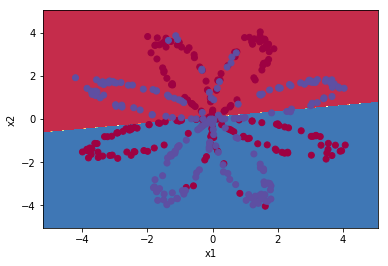

In [48]:
# 用clf对象来对数据集进行预测。我们为了简便起见，只用了训练数据集，其实应该用测试数据集的。
# 返回的结果LR_predictions中包含的是400个0或1，表示对400个点颜色的预测结果。
LR_predictions = clf.predict(X.T)

# 打印出预测准确度。下面是用了自定义的一个算法来求准确度，其实也可以简单地用clf的方法来求——clf.score(X.T,Y.T.ravel())
print ('预测准确度是: %d ' % float((np.dot(Y, LR_predictions) + np.dot(1 - Y,1 - LR_predictions)) / float(Y.size) * 100) + '% ')

# 画出预测结果图。
# 可以看到，这个单神经元网络只是简单地认为在坐标上面部分的点大致就是红色的，位于坐标下半部分的就是蓝色。
# 还是那句话，如果python功底不深的话，没有必要进去看plot_decision_boundary的实现代码。
# 我简单直观地描述下这个函数。首先，在这个函数里面，会将整个坐标的点（不仅仅是待预测花形点集X）传入到clf.predict中，
# 来得出坐标中每一个点的颜色预测值，然后根据它们画出底图（就是坐标上半部是红色下半部是蓝色的图）。
# 最后，再将待预测点集X画到底图上。通过底图和待预测点集的重叠，就可以很直观地看出神经网络预测的精准度。
# 例如，本例中预测得就很不准确，单神经元网络只是简单地认为坐标上部的点是红色，但实际上上面还有很多蓝色点，而且下面也有很多红色点。
plot_decision_boundary(lambda x: clf.predict(x), X, Y.ravel())

上面我们构建的单神经元网络预测得很不准确，下面我们将构建一个多神经元的浅层神经网络来进行同样的任务。没有对比就没有伤害~ 你会发现单神经元网络实在太弱。

我们还是老套路，先将浅层神经网络需要的各个部件各个工具函数编写好，然后再将这些函数组合起来形成一个完整的神经网络模型，然后用这个模型来训练参数，最后用训练好的参数来进行预测。

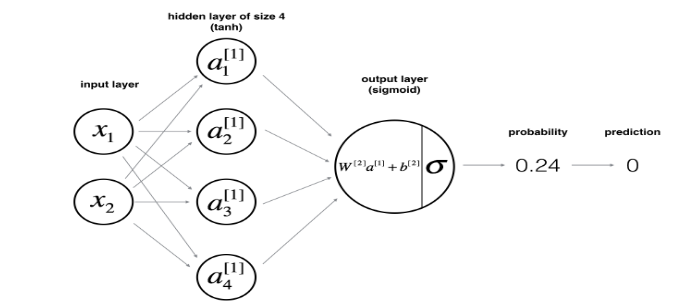

In [49]:
# 初始化参数w和b。
# 这个在单神经元实战时也有，但是那时是全都初始化为0，在多神经网络中是万万不可全初始化为0的。

def initialize_parameters(n_x, n_h, n_y):
    """
    参数:
    n_x -- 输入层的神经元个数
    n_h -- 隐藏层的神经元个数
    n_y -- 输出层的神经元个数
    """
    
    np.random.seed(2)
    
    # 随机初始化第一层（隐藏层）相关的参数w.
    # 每一个隐藏层神经元都与输入层的每一个神经元相连。每一个相连都会有一个对应的参数w。
    # 所以W1的维度是（n_h, n_x）,表示（隐藏层的神经元个数，输入层神经元个数）
    W1 = np.random.randn(n_h, n_x) * 0.01
    
    # 将第一层的参数b赋值为0，因为w已经非0了，所以b可以为0
    # 因为每一个神经元只有一个对应的b，所以b1的维度是(n_h, 1)，表示（隐藏层神经元个数，1）
    b1 = np.zeros(shape=(n_h, 1))
    
    # 同理，初始化第二层的w和b
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    # 将初始化好的参数放入一个字典变量中
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [50]:
# 这是针对于initialize_parameters函数的单元测试
# 在上一个实战编程中，不少同学在实现自己的版本期间，出现了问题，但是又很难定位问题出在哪里~~ 所以以后在每个函数后面都会加入一个单元测试
# 如果你在实现自己的版本时，发现某个函数的单元测试的输出结果和我的不一致，那么问题应该就出现在那个函数里面。
# 当然，由于python的版本可能不同，所以默认设置不同，可能会出现小数精度不一致，但是小数位前面的是一致的或结果差不多就没有问题
# 单元测试的实现细节你不需要太关心
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

print("--------------------------------------------")

print("nn dim(" + str(n_x) + "," + str(n_h) + "," + str(n_y) + ")");
print("W1 dim:" + str(parameters["W1"].shape))
print("b1 dim:" + str(parameters["b1"].shape))
print("W2 dim:" + str(parameters["W2"].shape))
print("b2 dim:" + str(parameters["b2"].shape))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]
--------------------------------------------
nn dim(2,4,1)
W1 dim:(4, 2)
b1 dim:(4, 1)
W2 dim:(1, 4)
b2 dim:(1, 1)


In [51]:
# 初始化了参数后，就是我们熟悉的前向传播了
def forward_propagation(X, parameters):
    """
    参数:
    X -- 输入特征，维度是 (横纵坐标, 样本数)
    parameters -- 参数w和b
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    
    m = X.shape[1] # 获取样本数
#     print("样本数：" + str(m))
    
    # 从字典中取出参数
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # 实现前向传播算法
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1) # 第一层的激活函数我们使用tanh。numpy库里面已经帮我们实现了tanh工具函数
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2) # 第二层我们使用sigmoid，因为我们要解决的这个问题属于二分问题。这个函数是我们自己在planar_utils里面实现的。

    # 将这些前向传播时得出的值保存起来，因为在后面进行反向传播计算时会用到他们。
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [52]:
# 单元测试
X_assess, parameters = forward_propagation_test_case()

A2, cache = forward_propagation(X_assess, parameters)

print(np.mean(cache['Z1']), np.mean(cache['A1']), np.mean(cache['Z2']), np.mean(cache['A2']))

print("--------------------------------------------")

print("W1 dim:" + str(parameters["W1"].shape))
print("b1 dim:" + str(parameters["b1"].shape))
print("W2 dim:" + str(parameters["W2"].shape))
print("b2 dim:" + str(parameters["b2"].shape))

print("--------------------------------------------")

print("Z1 dim:" + str(cache['Z1'].shape))
print("A1 dim:" + str(cache['A1'].shape))
print("Z2 dim:" + str(cache['Z2'].shape))
print("A2 dim:" + str(cache['A2'].shape))

-0.0004997557777419902 -0.000496963353231779 0.00043818745095914653 0.500109546852431
--------------------------------------------
W1 dim:(4, 2)
b1 dim:(4, 1)
W2 dim:(1, 4)
b2 dim:(1, 1)
--------------------------------------------
Z1 dim:(4, 3)
A1 dim:(4, 3)
Z2 dim:(1, 3)
A2 dim:(1, 3)


In [53]:
# 这个函数被用来计算成本
def compute_cost(A2, Y, parameters):
    """   
    参数:
    A2 -- 神经网络最后一层的输出结果
    Y -- 数据的颜色标签
    """
    
    m = Y.shape[1] 
    
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    
    return cost

In [54]:
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.6929198937761266


In [55]:
# 然后就是反向传播
def backward_propagation(parameters, cache, X, Y):
    """
    参数:
    parameters -- 参数w和b
    cache -- 前向传播时保存起来的一些数据
    X -- 输入特征
    Y -- 标签
    """
    m = X.shape[1] # 获取样本数
    
    W1 = parameters['W1']
    W2 = parameters['W2']
        
    A1 = cache['A1']
    A2 = cache['A2']
    
    # 根据我们文章中介绍的算法公式来计算梯度（偏导数）
    dZ2= A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
#     print("W1 dim:" + str(W1.shape))
#     print("W2 dim:" + str(W2.shape))
#     print("------------------------------")
    
#     print("dZ2 dim:" + str(dZ2.shape))
#     print("dZ1 dim:" + str(dZ1.shape))
#     print("------------------------------")
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads # 返回计算得到的梯度

In [56]:
# 单元测试
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)

print("dW1 dim:" + str(grads["dW1"].shape))
print("db1 dim:" + str(grads["db1"].shape))
print("dW2 dim:" + str(grads["dW2"].shape))
print("db2 dim:" + str(grads["db2"].shape))
print("------------------------------")

print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 dim:(4, 2)
db1 dim:(4, 1)
dW2 dim:(1, 4)
db2 dim:(1, 1)
------------------------------
dW1 = [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1 = [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[0.06589489]]


In [57]:
# 用上面得到的梯度来进行梯度下降（更新参数w和b，使其更优化）
def update_parameters(parameters, grads, learning_rate=1.2):
    """
    参数:
    parameters -- 参数w和b 
    grads -- 梯度
    """

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    # 根据梯度和学习率来更新参数，使其更优
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [58]:
# 单元测试
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


In [59]:
# 上面已经将各个所需的功能函数都编写好了。现在我们将它们组合在一个大函数中来构建出一个训练模型。
def nn_model(X, Y, n_h, num_iterations=10000, print_cost=False):
    """
    Arguments:
    X -- 输入特征
    Y -- 标签
    n_h -- 隐藏层的神经元个数
    num_iterations -- 训练多少次
    print_cost -- 是否打印出成本
    """
    
    np.random.seed(3)
    n_x = X.shape[0] # 根据输入特征的维度得出输入层的神经元个数
    n_y = Y.shape[0] # 根据标签的维度得出输出层的神经元个数
    

    # 初始化参数
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # 在这个循环里进行训练，一次一次地对参数进行优化
    for i in range(0, num_iterations):
        # 进行前向传播
        A2, cache = forward_propagation(X, parameters)
        
        # 计算出本次的成本
        cost = compute_cost(A2, Y, parameters)
        print("i = {} cost = {}".format(i, cost))
 
        # 进行反向传播。根据前向传播得到的一些值算出梯度。
        grads = backward_propagation(parameters, cache, X, Y)
 
        # 根据梯度对参数进行一次优化（下降）
        parameters = update_parameters(parameters, grads)
                
        # 将本次训练的成本打印出来
        if print_cost and i % 1000 == 0:
            print ("在训练%i次后，成本是: %f" % (i, cost))

    return parameters

In [60]:
# 单元测试
X_assess, Y_assess = nn_model_test_case()

parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=False)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

i = 0 cost = 0.6925839035679378
i = 1 cost = 0.6841853207652274
i = 2 cost = 0.6599112784860952
i = 3 cost = 0.5407200741362388
i = 4 cost = 0.10195127023315505
i = 5 cost = -0.6546047327602557
i = 6 cost = -1.544196957604587
i = 7 cost = -2.5262140419699386
i = 8 cost = -3.5979931805864758
i = 9 cost = -4.449779469805747
i = 10 cost = -3.8762053416272355
i = 11 cost = -5.89979638293741
i = 12 cost = -7.3953490729276865
i = 13 cost = -8.858293364514232
i = 14 cost = -10.10192794080709
i = 15 cost = -11.334442462631591
i = 16 cost = -12.555972987256958
i = 17 cost = -13.769632646056259
i = 18 cost = -14.97951199218488
i = 19 cost = -16.19108954193308
i = 20 cost = -17.383641894562317
i = 21 cost = -inf
i = 22 cost = -inf
i = 23 cost = -inf
i = 24 cost = -inf
i = 25 cost = -inf
i = 26 cost = -inf
i = 27 cost = -inf
i = 28 cost = -inf
i = 29 cost = -inf
i = 30 cost = -inf
i = 31 cost = -inf
i = 32 cost = -inf
i = 33 cost = -inf
i = 34 cost = -inf
i = 35 cost = -inf
i = 36 cost = -inf
i = 

i = 403 cost = -inf
i = 404 cost = -inf
i = 405 cost = -inf
i = 406 cost = -inf
i = 407 cost = -inf
i = 408 cost = -inf
i = 409 cost = -inf
i = 410 cost = -inf
i = 411 cost = -inf
i = 412 cost = -inf
i = 413 cost = -inf
i = 414 cost = -inf
i = 415 cost = -inf
i = 416 cost = -inf
i = 417 cost = -inf
i = 418 cost = -inf
i = 419 cost = -inf
i = 420 cost = -inf
i = 421 cost = -inf
i = 422 cost = -inf
i = 423 cost = -inf
i = 424 cost = -inf
i = 425 cost = -inf
i = 426 cost = -inf
i = 427 cost = -inf
i = 428 cost = -inf
i = 429 cost = -inf
i = 430 cost = -inf
i = 431 cost = -inf
i = 432 cost = -inf
i = 433 cost = -inf
i = 434 cost = -inf
i = 435 cost = -inf
i = 436 cost = -inf
i = 437 cost = -inf
i = 438 cost = -inf
i = 439 cost = -inf
i = 440 cost = -inf
i = 441 cost = -inf
i = 442 cost = -inf
i = 443 cost = -inf
i = 444 cost = -inf
i = 445 cost = -inf
i = 446 cost = -inf
i = 447 cost = -inf
i = 448 cost = -inf
i = 449 cost = -inf
i = 450 cost = -inf
i = 451 cost = -inf
i = 452 cost = -inf


i = 832 cost = -inf


/Users/xm210408/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


i = 833 cost = -inf
i = 834 cost = -inf
i = 835 cost = -inf
i = 836 cost = -inf
i = 837 cost = -inf
i = 838 cost = -inf
i = 839 cost = -inf
i = 840 cost = -inf
i = 841 cost = -inf
i = 842 cost = -inf
i = 843 cost = -inf
i = 844 cost = -inf
i = 845 cost = -inf
i = 846 cost = -inf
i = 847 cost = -inf
i = 848 cost = -inf
i = 849 cost = -inf
i = 850 cost = -inf
i = 851 cost = -inf
i = 852 cost = -inf
i = 853 cost = -inf
i = 854 cost = -inf
i = 855 cost = -inf
i = 856 cost = -inf
i = 857 cost = -inf
i = 858 cost = -inf
i = 859 cost = -inf
i = 860 cost = -inf
i = 861 cost = -inf
i = 862 cost = -inf
i = 863 cost = -inf
i = 864 cost = -inf
i = 865 cost = -inf
i = 866 cost = -inf
i = 867 cost = -inf
i = 868 cost = -inf
i = 869 cost = -inf
i = 870 cost = -inf
i = 871 cost = -inf
i = 872 cost = -inf
i = 873 cost = -inf
i = 874 cost = -inf
i = 875 cost = -inf
i = 876 cost = -inf
i = 877 cost = -inf
i = 878 cost = -inf
i = 879 cost = -inf
i = 880 cost = -inf
i = 881 cost = -inf
i = 882 cost = -inf


i = 1364 cost = -inf
i = 1365 cost = -inf
i = 1366 cost = -inf
i = 1367 cost = -inf
i = 1368 cost = -inf
i = 1369 cost = -inf
i = 1370 cost = -inf
i = 1371 cost = -inf
i = 1372 cost = -inf
i = 1373 cost = -inf
i = 1374 cost = -inf
i = 1375 cost = -inf
i = 1376 cost = -inf
i = 1377 cost = -inf
i = 1378 cost = -inf
i = 1379 cost = -inf
i = 1380 cost = -inf
i = 1381 cost = -inf
i = 1382 cost = -inf
i = 1383 cost = -inf
i = 1384 cost = -inf
i = 1385 cost = -inf
i = 1386 cost = -inf
i = 1387 cost = -inf
i = 1388 cost = -inf
i = 1389 cost = -inf
i = 1390 cost = -inf
i = 1391 cost = -inf
i = 1392 cost = -inf
i = 1393 cost = -inf
i = 1394 cost = -inf
i = 1395 cost = -inf
i = 1396 cost = -inf
i = 1397 cost = -inf
i = 1398 cost = -inf
i = 1399 cost = -inf
i = 1400 cost = -inf
i = 1401 cost = -inf
i = 1402 cost = -inf
i = 1403 cost = -inf
i = 1404 cost = -inf
i = 1405 cost = -inf
i = 1406 cost = -inf
i = 1407 cost = -inf
i = 1408 cost = -inf
i = 1409 cost = -inf
i = 1410 cost = -inf
i = 1411 cost

i = 1917 cost = -inf
i = 1918 cost = -inf
i = 1919 cost = -inf
i = 1920 cost = -inf
i = 1921 cost = -inf
i = 1922 cost = -inf
i = 1923 cost = -inf
i = 1924 cost = -inf
i = 1925 cost = -inf
i = 1926 cost = -inf
i = 1927 cost = -inf
i = 1928 cost = -inf
i = 1929 cost = -inf
i = 1930 cost = -inf
i = 1931 cost = -inf
i = 1932 cost = -inf
i = 1933 cost = -inf
i = 1934 cost = -inf
i = 1935 cost = -inf
i = 1936 cost = -inf
i = 1937 cost = -inf
i = 1938 cost = -inf
i = 1939 cost = -inf
i = 1940 cost = -inf
i = 1941 cost = -inf
i = 1942 cost = -inf
i = 1943 cost = -inf
i = 1944 cost = -inf
i = 1945 cost = -inf
i = 1946 cost = -inf
i = 1947 cost = -inf
i = 1948 cost = -inf
i = 1949 cost = -inf
i = 1950 cost = -inf
i = 1951 cost = -inf
i = 1952 cost = -inf
i = 1953 cost = -inf
i = 1954 cost = -inf
i = 1955 cost = -inf
i = 1956 cost = -inf
i = 1957 cost = -inf
i = 1958 cost = -inf
i = 1959 cost = -inf
i = 1960 cost = -inf
i = 1961 cost = -inf
i = 1962 cost = -inf
i = 1963 cost = -inf
i = 1964 cost

i = 2478 cost = -inf
i = 2479 cost = -inf
i = 2480 cost = -inf
i = 2481 cost = -inf
i = 2482 cost = -inf
i = 2483 cost = -inf
i = 2484 cost = -inf
i = 2485 cost = -inf
i = 2486 cost = -inf
i = 2487 cost = -inf
i = 2488 cost = -inf
i = 2489 cost = -inf
i = 2490 cost = -inf
i = 2491 cost = -inf
i = 2492 cost = -inf
i = 2493 cost = -inf
i = 2494 cost = -inf
i = 2495 cost = -inf
i = 2496 cost = -inf
i = 2497 cost = -inf
i = 2498 cost = -inf
i = 2499 cost = -inf
i = 2500 cost = -inf
i = 2501 cost = -inf
i = 2502 cost = -inf
i = 2503 cost = -inf
i = 2504 cost = -inf
i = 2505 cost = -inf
i = 2506 cost = -inf
i = 2507 cost = -inf
i = 2508 cost = -inf
i = 2509 cost = -inf
i = 2510 cost = -inf
i = 2511 cost = -inf
i = 2512 cost = -inf
i = 2513 cost = -inf
i = 2514 cost = -inf
i = 2515 cost = -inf
i = 2516 cost = -inf
i = 2517 cost = -inf
i = 2518 cost = -inf
i = 2519 cost = -inf
i = 2520 cost = -inf
i = 2521 cost = -inf
i = 2522 cost = -inf
i = 2523 cost = -inf
i = 2524 cost = -inf
i = 2525 cost

i = 2995 cost = -inf
i = 2996 cost = -inf
i = 2997 cost = -inf
i = 2998 cost = -inf
i = 2999 cost = -inf
i = 3000 cost = -inf
i = 3001 cost = -inf
i = 3002 cost = -inf
i = 3003 cost = -inf
i = 3004 cost = -inf
i = 3005 cost = -inf
i = 3006 cost = -inf
i = 3007 cost = -inf
i = 3008 cost = -inf
i = 3009 cost = -inf
i = 3010 cost = -inf
i = 3011 cost = -inf
i = 3012 cost = -inf
i = 3013 cost = -inf
i = 3014 cost = -inf
i = 3015 cost = -inf
i = 3016 cost = -inf
i = 3017 cost = -inf
i = 3018 cost = -inf
i = 3019 cost = -inf
i = 3020 cost = -inf
i = 3021 cost = -inf
i = 3022 cost = -inf
i = 3023 cost = -inf
i = 3024 cost = -inf
i = 3025 cost = -inf
i = 3026 cost = -inf
i = 3027 cost = -inf
i = 3028 cost = -inf
i = 3029 cost = -inf
i = 3030 cost = -inf
i = 3031 cost = -inf
i = 3032 cost = -inf
i = 3033 cost = -inf
i = 3034 cost = -inf
i = 3035 cost = -inf
i = 3036 cost = -inf
i = 3037 cost = -inf
i = 3038 cost = -inf
i = 3039 cost = -inf
i = 3040 cost = -inf
i = 3041 cost = -inf
i = 3042 cost

i = 3593 cost = -inf
i = 3594 cost = -inf
i = 3595 cost = -inf
i = 3596 cost = -inf
i = 3597 cost = -inf
i = 3598 cost = -inf
i = 3599 cost = -inf
i = 3600 cost = -inf
i = 3601 cost = -inf
i = 3602 cost = -inf
i = 3603 cost = -inf
i = 3604 cost = -inf
i = 3605 cost = -inf
i = 3606 cost = -inf
i = 3607 cost = -inf
i = 3608 cost = -inf
i = 3609 cost = -inf
i = 3610 cost = -inf
i = 3611 cost = -inf
i = 3612 cost = -inf
i = 3613 cost = -inf
i = 3614 cost = -inf
i = 3615 cost = -inf
i = 3616 cost = -inf
i = 3617 cost = -inf
i = 3618 cost = -inf
i = 3619 cost = -inf
i = 3620 cost = -inf
i = 3621 cost = -inf
i = 3622 cost = -inf
i = 3623 cost = -inf
i = 3624 cost = -inf
i = 3625 cost = -inf
i = 3626 cost = -inf
i = 3627 cost = -inf
i = 3628 cost = -inf
i = 3629 cost = -inf
i = 3630 cost = -inf
i = 3631 cost = -inf
i = 3632 cost = -inf
i = 3633 cost = -inf
i = 3634 cost = -inf
i = 3635 cost = -inf
i = 3636 cost = -inf
i = 3637 cost = -inf
i = 3638 cost = -inf
i = 3639 cost = -inf
i = 3640 cost

i = 4170 cost = -inf
i = 4171 cost = -inf
i = 4172 cost = -inf
i = 4173 cost = -inf
i = 4174 cost = -inf
i = 4175 cost = -inf
i = 4176 cost = -inf
i = 4177 cost = -inf
i = 4178 cost = -inf
i = 4179 cost = -inf
i = 4180 cost = -inf
i = 4181 cost = -inf
i = 4182 cost = -inf
i = 4183 cost = -inf
i = 4184 cost = -inf
i = 4185 cost = -inf
i = 4186 cost = -inf
i = 4187 cost = -inf
i = 4188 cost = -inf
i = 4189 cost = -inf
i = 4190 cost = -inf
i = 4191 cost = -inf
i = 4192 cost = -inf
i = 4193 cost = -inf
i = 4194 cost = -inf
i = 4195 cost = -inf
i = 4196 cost = -inf
i = 4197 cost = -inf
i = 4198 cost = -inf
i = 4199 cost = -inf
i = 4200 cost = -inf
i = 4201 cost = -inf
i = 4202 cost = -inf
i = 4203 cost = -inf
i = 4204 cost = -inf
i = 4205 cost = -inf
i = 4206 cost = -inf
i = 4207 cost = -inf
i = 4208 cost = -inf
i = 4209 cost = -inf
i = 4210 cost = -inf
i = 4211 cost = -inf
i = 4212 cost = -inf
i = 4213 cost = -inf
i = 4214 cost = -inf
i = 4215 cost = -inf
i = 4216 cost = -inf
i = 4217 cost

i = 4890 cost = -inf
i = 4891 cost = -inf
i = 4892 cost = -inf
i = 4893 cost = -inf
i = 4894 cost = -inf
i = 4895 cost = -inf
i = 4896 cost = -inf
i = 4897 cost = -inf
i = 4898 cost = -inf
i = 4899 cost = -inf
i = 4900 cost = -inf
i = 4901 cost = -inf
i = 4902 cost = -inf
i = 4903 cost = -inf
i = 4904 cost = -inf
i = 4905 cost = -inf
i = 4906 cost = -inf
i = 4907 cost = -inf
i = 4908 cost = -inf
i = 4909 cost = -inf
i = 4910 cost = -inf
i = 4911 cost = -inf
i = 4912 cost = -inf
i = 4913 cost = -inf
i = 4914 cost = -inf
i = 4915 cost = -inf
i = 4916 cost = -inf
i = 4917 cost = -inf
i = 4918 cost = -inf
i = 4919 cost = -inf
i = 4920 cost = -inf
i = 4921 cost = -inf
i = 4922 cost = -inf
i = 4923 cost = -inf
i = 4924 cost = -inf
i = 4925 cost = -inf
i = 4926 cost = -inf
i = 4927 cost = -inf
i = 4928 cost = -inf
i = 4929 cost = -inf
i = 4930 cost = -inf
i = 4931 cost = -inf
i = 4932 cost = -inf
i = 4933 cost = -inf
i = 4934 cost = -inf
i = 4935 cost = -inf
i = 4936 cost = -inf
i = 4937 cost

i = 5573 cost = -inf
i = 5574 cost = -inf
i = 5575 cost = -inf
i = 5576 cost = -inf
i = 5577 cost = -inf
i = 5578 cost = -inf
i = 5579 cost = -inf
i = 5580 cost = -inf
i = 5581 cost = -inf
i = 5582 cost = -inf
i = 5583 cost = -inf
i = 5584 cost = -inf
i = 5585 cost = -inf
i = 5586 cost = -inf
i = 5587 cost = -inf
i = 5588 cost = -inf
i = 5589 cost = -inf
i = 5590 cost = -inf
i = 5591 cost = -inf
i = 5592 cost = -inf
i = 5593 cost = -inf
i = 5594 cost = -inf
i = 5595 cost = -inf
i = 5596 cost = -inf
i = 5597 cost = -inf
i = 5598 cost = -inf
i = 5599 cost = -inf
i = 5600 cost = -inf
i = 5601 cost = -inf
i = 5602 cost = -inf
i = 5603 cost = -inf
i = 5604 cost = -inf
i = 5605 cost = -inf
i = 5606 cost = -inf
i = 5607 cost = -inf
i = 5608 cost = -inf
i = 5609 cost = -inf
i = 5610 cost = -inf
i = 5611 cost = -inf
i = 5612 cost = -inf
i = 5613 cost = -inf
i = 5614 cost = -inf
i = 5615 cost = -inf
i = 5616 cost = -inf
i = 5617 cost = -inf
i = 5618 cost = -inf
i = 5619 cost = -inf
i = 5620 cost

i = 6347 cost = -inf
i = 6348 cost = -inf
i = 6349 cost = -inf
i = 6350 cost = -inf
i = 6351 cost = -inf
i = 6352 cost = -inf
i = 6353 cost = -inf
i = 6354 cost = -inf
i = 6355 cost = -inf
i = 6356 cost = -inf
i = 6357 cost = -inf
i = 6358 cost = -inf
i = 6359 cost = -inf
i = 6360 cost = -inf
i = 6361 cost = -inf
i = 6362 cost = -inf
i = 6363 cost = -inf
i = 6364 cost = -inf
i = 6365 cost = -inf
i = 6366 cost = -inf
i = 6367 cost = -inf
i = 6368 cost = -inf
i = 6369 cost = -inf
i = 6370 cost = -inf
i = 6371 cost = -inf
i = 6372 cost = -inf
i = 6373 cost = -inf
i = 6374 cost = -inf
i = 6375 cost = -inf
i = 6376 cost = -inf
i = 6377 cost = -inf
i = 6378 cost = -inf
i = 6379 cost = -inf
i = 6380 cost = -inf
i = 6381 cost = -inf
i = 6382 cost = -inf
i = 6383 cost = -inf
i = 6384 cost = -inf
i = 6385 cost = -inf
i = 6386 cost = -inf
i = 6387 cost = -inf
i = 6388 cost = -inf
i = 6389 cost = -inf
i = 6390 cost = -inf
i = 6391 cost = -inf
i = 6392 cost = -inf
i = 6393 cost = -inf
i = 6394 cost

i = 6793 cost = -inf
i = 6794 cost = -inf
i = 6795 cost = -inf
i = 6796 cost = -inf
i = 6797 cost = -inf
i = 6798 cost = -inf
i = 6799 cost = -inf
i = 6800 cost = -inf
i = 6801 cost = -inf
i = 6802 cost = -inf
i = 6803 cost = -inf
i = 6804 cost = -inf
i = 6805 cost = -inf
i = 6806 cost = -inf
i = 6807 cost = -inf
i = 6808 cost = -inf
i = 6809 cost = -inf
i = 6810 cost = -inf
i = 6811 cost = -inf
i = 6812 cost = -inf
i = 6813 cost = -inf
i = 6814 cost = -inf
i = 6815 cost = -inf
i = 6816 cost = -inf
i = 6817 cost = -inf
i = 6818 cost = -inf
i = 6819 cost = -inf
i = 6820 cost = -inf
i = 6821 cost = -inf
i = 6822 cost = -inf
i = 6823 cost = -inf
i = 6824 cost = -inf
i = 6825 cost = -inf
i = 6826 cost = -inf
i = 6827 cost = -inf
i = 6828 cost = -inf
i = 6829 cost = -inf
i = 6830 cost = -inf
i = 6831 cost = -inf
i = 6832 cost = -inf
i = 6833 cost = -inf
i = 6834 cost = -inf
i = 6835 cost = -inf
i = 6836 cost = -inf
i = 6837 cost = -inf
i = 6838 cost = -inf
i = 6839 cost = -inf
i = 6840 cost

i = 7762 cost = -inf
i = 7763 cost = -inf
i = 7764 cost = -inf
i = 7765 cost = -inf
i = 7766 cost = -inf
i = 7767 cost = -inf
i = 7768 cost = -inf
i = 7769 cost = -inf
i = 7770 cost = -inf
i = 7771 cost = -inf
i = 7772 cost = -inf
i = 7773 cost = -inf
i = 7774 cost = -inf
i = 7775 cost = -inf
i = 7776 cost = -inf
i = 7777 cost = -inf
i = 7778 cost = -inf
i = 7779 cost = -inf
i = 7780 cost = -inf
i = 7781 cost = -inf
i = 7782 cost = -inf
i = 7783 cost = -inf
i = 7784 cost = -inf
i = 7785 cost = -inf
i = 7786 cost = -inf
i = 7787 cost = -inf
i = 7788 cost = -inf
i = 7789 cost = -inf
i = 7790 cost = -inf
i = 7791 cost = -inf
i = 7792 cost = -inf
i = 7793 cost = -inf
i = 7794 cost = -inf
i = 7795 cost = -inf
i = 7796 cost = -inf
i = 7797 cost = -inf
i = 7798 cost = -inf
i = 7799 cost = -inf
i = 7800 cost = -inf
i = 7801 cost = -inf
i = 7802 cost = -inf
i = 7803 cost = -inf
i = 7804 cost = -inf
i = 7805 cost = -inf
i = 7806 cost = -inf
i = 7807 cost = -inf
i = 7808 cost = -inf
i = 7809 cost

i = 8346 cost = -inf
i = 8347 cost = -inf
i = 8348 cost = -inf
i = 8349 cost = -inf
i = 8350 cost = -inf
i = 8351 cost = -inf
i = 8352 cost = -inf
i = 8353 cost = -inf
i = 8354 cost = -inf
i = 8355 cost = -inf
i = 8356 cost = -inf
i = 8357 cost = -inf
i = 8358 cost = -inf
i = 8359 cost = -inf
i = 8360 cost = -inf
i = 8361 cost = -inf
i = 8362 cost = -inf
i = 8363 cost = -inf
i = 8364 cost = -inf
i = 8365 cost = -inf
i = 8366 cost = -inf
i = 8367 cost = -inf
i = 8368 cost = -inf
i = 8369 cost = -inf
i = 8370 cost = -inf
i = 8371 cost = -inf
i = 8372 cost = -inf
i = 8373 cost = -inf
i = 8374 cost = -inf
i = 8375 cost = -inf
i = 8376 cost = -inf
i = 8377 cost = -inf
i = 8378 cost = -inf
i = 8379 cost = -inf
i = 8380 cost = -inf
i = 8381 cost = -inf
i = 8382 cost = -inf
i = 8383 cost = -inf
i = 8384 cost = -inf
i = 8385 cost = -inf
i = 8386 cost = -inf
i = 8387 cost = -inf
i = 8388 cost = -inf
i = 8389 cost = -inf
i = 8390 cost = -inf
i = 8391 cost = -inf
i = 8392 cost = -inf
i = 8393 cost

i = 8974 cost = -inf
i = 8975 cost = -inf
i = 8976 cost = -inf
i = 8977 cost = -inf
i = 8978 cost = -inf
i = 8979 cost = -inf
i = 8980 cost = -inf
i = 8981 cost = -inf
i = 8982 cost = -inf
i = 8983 cost = -inf
i = 8984 cost = -inf
i = 8985 cost = -inf
i = 8986 cost = -inf
i = 8987 cost = -inf
i = 8988 cost = -inf
i = 8989 cost = -inf
i = 8990 cost = -inf
i = 8991 cost = -inf
i = 8992 cost = -inf
i = 8993 cost = -inf
i = 8994 cost = -inf
i = 8995 cost = -inf
i = 8996 cost = -inf
i = 8997 cost = -inf
i = 8998 cost = -inf
i = 8999 cost = -inf
i = 9000 cost = -inf
i = 9001 cost = -inf
i = 9002 cost = -inf
i = 9003 cost = -inf
i = 9004 cost = -inf
i = 9005 cost = -inf
i = 9006 cost = -inf
i = 9007 cost = -inf
i = 9008 cost = -inf
i = 9009 cost = -inf
i = 9010 cost = -inf
i = 9011 cost = -inf
i = 9012 cost = -inf
i = 9013 cost = -inf
i = 9014 cost = -inf
i = 9015 cost = -inf
i = 9016 cost = -inf
i = 9017 cost = -inf
i = 9018 cost = -inf
i = 9019 cost = -inf
i = 9020 cost = -inf
i = 9021 cost

i = 9966 cost = -inf
i = 9967 cost = -inf
i = 9968 cost = -inf
i = 9969 cost = -inf
i = 9970 cost = -inf
i = 9971 cost = -inf
i = 9972 cost = -inf
i = 9973 cost = -inf
i = 9974 cost = -inf
i = 9975 cost = -inf
i = 9976 cost = -inf
i = 9977 cost = -inf
i = 9978 cost = -inf
i = 9979 cost = -inf
i = 9980 cost = -inf
i = 9981 cost = -inf
i = 9982 cost = -inf
i = 9983 cost = -inf
i = 9984 cost = -inf
i = 9985 cost = -inf
i = 9986 cost = -inf
i = 9987 cost = -inf
i = 9988 cost = -inf
i = 9989 cost = -inf
i = 9990 cost = -inf
i = 9991 cost = -inf
i = 9992 cost = -inf
i = 9993 cost = -inf
i = 9994 cost = -inf
i = 9995 cost = -inf
i = 9996 cost = -inf
i = 9997 cost = -inf
i = 9998 cost = -inf
i = 9999 cost = -inf
W1 = [[-4.1849398   5.33220663]
 [-7.52989385  1.24306179]
 [-4.19294487  5.32632401]
 [ 7.52983712 -1.24309427]]
b1 = [[ 2.32926815]
 [ 3.79458991]
 [ 2.33002576]
 [-3.7946886 ]]
W2 = [[-6033.83672154 -6008.12980759 -6033.10095295  6008.06637359]]
b2 = [[-52.66607715]]


In [61]:
# 我们已经可以通过上面的函数来进行参数训练。
# 这个函数可以利用上面学习到的参数来对新数据进行预测
def predict(parameters, X):
    """    
    参数:
    parameters -- 训练得出的参数（学习到的参数）
    X -- 预测数据
    """
    
    # 预测其实就是简单地执行一次前向传播
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2) # 对结果进行四舍五入，小于0.5就是0，否则就是1
    
    return predictions

In [62]:
# 单元测试
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.6666666666666666


i = 0 cost = 0.6930480201239823
在训练0次后，成本是: 0.693048
i = 1 cost = 0.6929813036112868
i = 2 cost = 0.6928859307351817
i = 3 cost = 0.6927452093795846
i = 4 cost = 0.6925360700694462
i = 5 cost = 0.6922269715218793
i = 6 cost = 0.6917767417768662
i = 7 cost = 0.691136222258237
i = 8 cost = 0.6902557234455309
i = 9 cost = 0.6891011663032981
i = 10 cost = 0.6876776187311604
i = 11 cost = 0.6860493665328058
i = 12 cost = 0.6843375151582615
i = 13 cost = 0.6826846104233024
i = 14 cost = 0.6812030350577172
i = 15 cost = 0.6799417197582196
i = 16 cost = 0.6788894424737794
i = 17 cost = 0.678002253909729
i = 18 cost = 0.6772310833172195
i = 19 cost = 0.6765358033741053
i = 20 cost = 0.6758858155733588
i = 21 cost = 0.6752538504287032
i = 22 cost = 0.6746095625232692
i = 23 cost = 0.6739162682833677
i = 24 cost = 0.6731309445676453
i = 25 cost = 0.6722062000625048
i = 26 cost = 0.6710933291430475
i = 27 cost = 0.6697464858922356
i = 28 cost = 0.6681283056235787
i = 29 cost = 0.6662165753496646
i

i = 381 cost = 0.3127601670239663
i = 382 cost = 0.3126744267935207
i = 383 cost = 0.31258910393040035
i = 384 cost = 0.31250419460376533
i = 385 cost = 0.31241969503208755
i = 386 cost = 0.3123356014823229
i = 387 cost = 0.31225191026910165
i = 388 cost = 0.31216861775393495
i = 389 cost = 0.31208572034443777
i = 390 cost = 0.3120032144935683
i = 391 cost = 0.3119210966988825
i = 392 cost = 0.3118393635018038
i = 393 cost = 0.3117580114869077
i = 394 cost = 0.3116770372812215
i = 395 cost = 0.3115964375535369
i = 396 cost = 0.31151620901373756
i = 397 cost = 0.3114363484121393
i = 398 cost = 0.31135685253884415
i = 399 cost = 0.3112777182231065
i = 400 cost = 0.31119894233271206
i = 401 cost = 0.3111205217733692
i = 402 cost = 0.31104245348811244
i = 403 cost = 0.31096473445671663
i = 404 cost = 0.31088736169512354
i = 405 cost = 0.310810332254879
i = 406 cost = 0.31073364322258135
i = 407 cost = 0.3106572917193398
i = 408 cost = 0.31058127490024384
i = 409 cost = 0.3105055899538425
i

i = 625 cost = 0.2990140681950561
i = 626 cost = 0.29897503908260603
i = 627 cost = 0.29893609323369347
i = 628 cost = 0.29889723024372317
i = 629 cost = 0.29885844971089776
i = 630 cost = 0.29881975123619403
i = 631 cost = 0.2987811344233395
i = 632 cost = 0.29874259887878885
i = 633 cost = 0.29870414421170116
i = 634 cost = 0.29866577003391703
i = 635 cost = 0.29862747595993605
i = 636 cost = 0.2985892616068942
i = 637 cost = 0.2985511265945422
i = 638 cost = 0.29851307054522325
i = 639 cost = 0.2984750930838514
i = 640 cost = 0.29843719383789064
i = 641 cost = 0.29839937243733294
i = 642 cost = 0.2983616285146777
i = 643 cost = 0.29832396170491093
i = 644 cost = 0.29828637164548455
i = 645 cost = 0.29824885797629624
i = 646 cost = 0.29821142033966913
i = 647 cost = 0.2981740583803318
i = 648 cost = 0.2981367717453986
i = 649 cost = 0.2980995600843503
i = 650 cost = 0.2980624230490145
i = 651 cost = 0.2980253602935463
i = 652 cost = 0.29798837147441
i = 653 cost = 0.29795145625035935

i = 866 cost = 0.2913576431782412
i = 867 cost = 0.29133124605134975
i = 868 cost = 0.29130488203900823
i = 869 cost = 0.2912785510452828
i = 870 cost = 0.2912522529747334
i = 871 cost = 0.2912259877324108
i = 872 cost = 0.29119975522385333
i = 873 cost = 0.29117355535508327
i = 874 cost = 0.2911473880326042
i = 875 cost = 0.2911212531633979
i = 876 cost = 0.2910951506549205
i = 877 cost = 0.29106908041510027
i = 878 cost = 0.291043042352334
i = 879 cost = 0.29101703637548415
i = 880 cost = 0.2909910623938757
i = 881 cost = 0.29096512031729294
i = 882 cost = 0.2909392100559771
i = 883 cost = 0.29091333152062254
i = 884 cost = 0.2908874846223745
i = 885 cost = 0.29086166927282553
i = 886 cost = 0.2908358853840131
i = 887 cost = 0.29081013286841634
i = 888 cost = 0.2907844116389532
i = 889 cost = 0.2907587216089778
i = 890 cost = 0.2907330626922772
i = 891 cost = 0.29070743480306893
i = 892 cost = 0.2906818378559979
i = 893 cost = 0.2906562717661336
i = 894 cost = 0.2906307364489677
i = 

i = 1143 cost = 0.285061162041092
i = 1144 cost = 0.2850414300450433
i = 1145 cost = 0.2850217156974123
i = 1146 cost = 0.2850020189634399
i = 1147 cost = 0.28498233980842314
i = 1148 cost = 0.28496267819771454
i = 1149 cost = 0.284943034096721
i = 1150 cost = 0.28492340747090344
i = 1151 cost = 0.28490379828577583
i = 1152 cost = 0.2848842065069043
i = 1153 cost = 0.28486463209990687
i = 1154 cost = 0.28484507503045214
i = 1155 cost = 0.28482553526425897
i = 1156 cost = 0.28480601276709544
i = 1157 cost = 0.28478650750477835
i = 1158 cost = 0.2847670194431722
i = 1159 cost = 0.2847475485481887
i = 1160 cost = 0.2847280947857858
i = 1161 cost = 0.2847086581219672
i = 1162 cost = 0.2846892385227814
i = 1163 cost = 0.284669835954321
i = 1164 cost = 0.28465045038272196
i = 1165 cost = 0.2846310817741628
i = 1166 cost = 0.2846117300948642
i = 1167 cost = 0.2845923953110876
i = 1168 cost = 0.2845730773891351
i = 1169 cost = 0.28455377629534856
i = 1170 cost = 0.2845344919961083
i = 1171 cos

i = 1416 cost = 0.28021609137335596
i = 1417 cost = 0.2801998909373948
i = 1418 cost = 0.28018369786182434
i = 1419 cost = 0.2801675120915417
i = 1420 cost = 0.2801513335711603
i = 1421 cost = 0.2801351622450073
i = 1422 cost = 0.28011899805712115
i = 1423 cost = 0.28010284095124915
i = 1424 cost = 0.2800866908708444
i = 1425 cost = 0.28007054775906354
i = 1426 cost = 0.28005441155876387
i = 1427 cost = 0.28003828221250066
i = 1428 cost = 0.28002215966252453
i = 1429 cost = 0.2800060438507789
i = 1430 cost = 0.2799899347188966
i = 1431 cost = 0.27997383220819805
i = 1432 cost = 0.2799577362596877
i = 1433 cost = 0.2799416468140515
i = 1434 cost = 0.2799255638116542
i = 1435 cost = 0.27990948719253633
i = 1436 cost = 0.27989341689641145
i = 1437 cost = 0.279877352862663
i = 1438 cost = 0.279861295030342
i = 1439 cost = 0.2798452433381634
i = 1440 cost = 0.2798291977245036
i = 1441 cost = 0.2798131581273973
i = 1442 cost = 0.2797971244845346
i = 1443 cost = 0.2797810967332579
i = 1444 co

i = 1707 cost = 0.2754459012588968
i = 1708 cost = 0.27542729505380814
i = 1709 cost = 0.2754086531712165
i = 1710 cost = 0.2753899753307924
i = 1711 cost = 0.27537126125144745
i = 1712 cost = 0.2753525106513338
i = 1713 cost = 0.27533372324784283
i = 1714 cost = 0.2753148987576028
i = 1715 cost = 0.27529603689647575
i = 1716 cost = 0.27527713737955306
i = 1717 cost = 0.2752581999211501
i = 1718 cost = 0.2752392242347996
i = 1719 cost = 0.275220210033244
i = 1720 cost = 0.2752011570284257
i = 1721 cost = 0.27518206493147723
i = 1722 cost = 0.27516293345270865
i = 1723 cost = 0.27514376230159393
i = 1724 cost = 0.27512455118675566
i = 1725 cost = 0.27510529981594806
i = 1726 cost = 0.2750860078960379
i = 1727 cost = 0.27506667513298333
i = 1728 cost = 0.2750473012318114
i = 1729 cost = 0.27502788589659244
i = 1730 cost = 0.2750084288304125
i = 1731 cost = 0.2749889297353438
i = 1732 cost = 0.27496938831241213
i = 1733 cost = 0.2749498042615617
i = 1734 cost = 0.27493017728161706
i = 173

i = 2049 cost = 0.2522215198926424
i = 2050 cost = 0.2521817829295942
i = 2051 cost = 0.25214216260490174
i = 2052 cost = 0.25210265727836684
i = 2053 cost = 0.2520632653812302
i = 2054 cost = 0.25202398541237875
i = 2055 cost = 0.2519848159347557
i = 2056 cost = 0.2519457555719639
i = 2057 cost = 0.2519068030050511
i = 2058 cost = 0.2518679569694676
i = 2059 cost = 0.2518292162521876
i = 2060 cost = 0.25179057968898483
i = 2061 cost = 0.2517520461618547
i = 2062 cost = 0.2517136145965751
i = 2063 cost = 0.2516752839603981
i = 2064 cost = 0.25163705325986685
i = 2065 cost = 0.2515989215387489
i = 2066 cost = 0.2515608878760822
i = 2067 cost = 0.2515229513843257
i = 2068 cost = 0.2514851112076102
i = 2069 cost = 0.2514473665200847
i = 2070 cost = 0.2514097165243502
i = 2071 cost = 0.2513721604499805
i = 2072 cost = 0.25133469755212245
i = 2073 cost = 0.25129732711017144
i = 2074 cost = 0.25126004842652017
i = 2075 cost = 0.2512228608253743
i = 2076 cost = 0.25118576365163364
i = 2077 co

i = 2415 cost = 0.24205177320219218
i = 2416 cost = 0.2420319245375533
i = 2417 cost = 0.24201210556302422
i = 2418 cost = 0.2419923162047617
i = 2419 cost = 0.24197255638917348
i = 2420 cost = 0.24195282604291726
i = 2421 cost = 0.2419331250928996
i = 2422 cost = 0.24191345346627444
i = 2423 cost = 0.24189381109044247
i = 2424 cost = 0.24187419789304979
i = 2425 cost = 0.24185461380198675
i = 2426 cost = 0.2418350587453869
i = 2427 cost = 0.24181553265162598
i = 2428 cost = 0.2417960354493208
i = 2429 cost = 0.241776567067328
i = 2430 cost = 0.24175712743474334
i = 2431 cost = 0.24173771648090014
i = 2432 cost = 0.24171833413536872
i = 2433 cost = 0.2416989803279551
i = 2434 cost = 0.24167965498869975
i = 2435 cost = 0.2416603580478771
i = 2436 cost = 0.2416410894359939
i = 2437 cost = 0.2416218490837887
i = 2438 cost = 0.24160263692223047
i = 2439 cost = 0.24158345288251773
i = 2440 cost = 0.2415642968960776
i = 2441 cost = 0.24154516889456462
i = 2442 cost = 0.24152606880986002
i = 

i = 2735 cost = 0.23690016698706912
i = 2736 cost = 0.2368870533929931
i = 2737 cost = 0.23687395449667648
i = 2738 cost = 0.2368608702694484
i = 2739 cost = 0.23684780068271305
i = 2740 cost = 0.23683474570794927
i = 2741 cost = 0.23682170531671048
i = 2742 cost = 0.23680867948062415
i = 2743 cost = 0.23679566817139183
i = 2744 cost = 0.2367826713607889
i = 2745 cost = 0.23676968902066414
i = 2746 cost = 0.23675672112293966
i = 2747 cost = 0.2367437676396106
i = 2748 cost = 0.23673082854274485
i = 2749 cost = 0.236717903804483
i = 2750 cost = 0.23670499339703777
i = 2751 cost = 0.23669209729269425
i = 2752 cost = 0.23667921546380918
i = 2753 cost = 0.23666634788281096
i = 2754 cost = 0.23665349452219955
i = 2755 cost = 0.23664065535454604
i = 2756 cost = 0.23662783035249235
i = 2757 cost = 0.23661501948875116
i = 2758 cost = 0.2366022227361058
i = 2759 cost = 0.23658944006740973
i = 2760 cost = 0.23657667145558656
i = 2761 cost = 0.23656391687362965
i = 2762 cost = 0.23655117629460196

i = 2994 cost = 0.23392453613002678
i = 2995 cost = 0.2339144488350576
i = 2996 cost = 0.23390437076237888
i = 2997 cost = 0.23389430189671243
i = 2998 cost = 0.23388424222281462
i = 2999 cost = 0.2338741917254761
i = 3000 cost = 0.23386415038952207
在训练3000次后，成本是: 0.233864
i = 3001 cost = 0.2338541181998118
i = 3002 cost = 0.23384409514123866
i = 3003 cost = 0.23383408119873017
i = 3004 cost = 0.23382407635724778
i = 3005 cost = 0.2338140806017867
i = 3006 cost = 0.23380409391737597
i = 3007 cost = 0.23379411628907826
i = 3008 cost = 0.23378414770198983
i = 3009 cost = 0.23377418814124035
i = 3010 cost = 0.23376423759199302
i = 3011 cost = 0.23375429603944425
i = 3012 cost = 0.23374436346882363
i = 3013 cost = 0.23373443986539377
i = 3014 cost = 0.2337245252144506
i = 3015 cost = 0.2337146195013227
i = 3016 cost = 0.23370472271137147
i = 3017 cost = 0.23369483482999123
i = 3018 cost = 0.23368495584260893
i = 3019 cost = 0.23367508573468393
i = 3020 cost = 0.23366522449170823
i = 3021 c

i = 3261 cost = 0.23151702961406506
i = 3262 cost = 0.23150895349342868
i = 3263 cost = 0.23150088349510584
i = 3264 cost = 0.23149281961041698
i = 3265 cost = 0.23148476183069974
i = 3266 cost = 0.23147671014730897
i = 3267 cost = 0.2314686645516166
i = 3268 cost = 0.2314606250350116
i = 3269 cost = 0.23145259158890005
i = 3270 cost = 0.23144456420470494
i = 3271 cost = 0.23143654287386628
i = 3272 cost = 0.2314285275878409
i = 3273 cost = 0.2314205183381027
i = 3274 cost = 0.23141251511614214
i = 3275 cost = 0.23140451791346664
i = 3276 cost = 0.23139652672160033
i = 3277 cost = 0.2313885415320839
i = 3278 cost = 0.23138056233647497
i = 3279 cost = 0.23137258912634764
i = 3280 cost = 0.23136462189329252
i = 3281 cost = 0.23135666062891688
i = 3282 cost = 0.2313487053248444
i = 3283 cost = 0.23134075597271533
i = 3284 cost = 0.23133281256418622
i = 3285 cost = 0.2313248750909301
i = 3286 cost = 0.23131694354463633
i = 3287 cost = 0.2313090179170105
i = 3288 cost = 0.23130109819977446


i = 3530 cost = 0.2295406403675461
i = 3531 cost = 0.22953394568031094
i = 3532 cost = 0.22952725528749185
i = 3533 cost = 0.22952056918383598
i = 3534 cost = 0.2295138873640999
i = 3535 cost = 0.22950720982304923
i = 3536 cost = 0.2295005365554587
i = 3537 cost = 0.22949386755611256
i = 3538 cost = 0.22948720281980386
i = 3539 cost = 0.22948054234133472
i = 3540 cost = 0.22947388611551672
i = 3541 cost = 0.22946723413717016
i = 3542 cost = 0.22946058640112457
i = 3543 cost = 0.2294539429022185
i = 3544 cost = 0.2294473036352995
i = 3545 cost = 0.22944066859522408
i = 3546 cost = 0.2294340377768578
i = 3547 cost = 0.2294274111750751
i = 3548 cost = 0.2294207887847595
i = 3549 cost = 0.22941417060080332
i = 3550 cost = 0.22940755661810777
i = 3551 cost = 0.229400946831583
i = 3552 cost = 0.22939434123614805
i = 3553 cost = 0.2293877398267307
i = 3554 cost = 0.2293811425982676
i = 3555 cost = 0.22937454954570427
i = 3556 cost = 0.22936796066399487
i = 3557 cost = 0.22936137594810255
i = 

i = 3813 cost = 0.22779991965120008
i = 3814 cost = 0.22779426051802118
i = 3815 cost = 0.22778860449671107
i = 3816 cost = 0.22778295158397996
i = 3817 cost = 0.22777730177654346
i = 3818 cost = 0.22777165507112201
i = 3819 cost = 0.22776601146444128
i = 3820 cost = 0.22776037095323204
i = 3821 cost = 0.22775473353423015
i = 3822 cost = 0.2277490992041763
i = 3823 cost = 0.2277434679598166
i = 3824 cost = 0.2277378397979019
i = 3825 cost = 0.22773221471518823
i = 3826 cost = 0.22772659270843665
i = 3827 cost = 0.22772097377441317
i = 3828 cost = 0.22771535790988878
i = 3829 cost = 0.2277097451116395
i = 3830 cost = 0.2277041353764464
i = 3831 cost = 0.2276985287010954
i = 3832 cost = 0.22769292508237748
i = 3833 cost = 0.22768732451708854
i = 3834 cost = 0.22768172700202943
i = 3835 cost = 0.22767613253400587
i = 3836 cost = 0.22767054110982862
i = 3837 cost = 0.22766495272631332
i = 3838 cost = 0.2276593673802804
i = 3839 cost = 0.22765378506855533
i = 3840 cost = 0.2276482057879684


i = 4073 cost = 0.22642465959691985
i = 4074 cost = 0.22641971191130503
i = 4075 cost = 0.22641476662896076
i = 4076 cost = 0.22640982374764426
i = 4077 cost = 0.22640488326511587
i = 4078 cost = 0.22639994517913908
i = 4079 cost = 0.22639500948748037
i = 4080 cost = 0.22639007618790938
i = 4081 cost = 0.22638514527819895
i = 4082 cost = 0.22638021675612485
i = 4083 cost = 0.22637529061946604
i = 4084 cost = 0.2263703668660046
i = 4085 cost = 0.22636544549352558
i = 4086 cost = 0.22636052649981722
i = 4087 cost = 0.22635560988267073
i = 4088 cost = 0.2263506956398804
i = 4089 cost = 0.2263457837692436
i = 4090 cost = 0.22634087426856084
i = 4091 cost = 0.22633596713563542
i = 4092 cost = 0.226331062368274
i = 4093 cost = 0.22632615996428598
i = 4094 cost = 0.22632125992148402
i = 4095 cost = 0.22631636223768362
i = 4096 cost = 0.22631146691070347
i = 4097 cost = 0.22630657393836517
i = 4098 cost = 0.22630168331849337
i = 4099 cost = 0.22629679504891562
i = 4100 cost = 0.226291909127462

i = 4348 cost = 0.22514756288481336
i = 4349 cost = 0.22514320112651232
i = 4350 cost = 0.22513884125545103
i = 4351 cost = 0.2251344832700678
i = 4352 cost = 0.22513012716880268
i = 4353 cost = 0.2251257729500977
i = 4354 cost = 0.2251214206123967
i = 4355 cost = 0.22511707015414573
i = 4356 cost = 0.22511272157379253
i = 4357 cost = 0.22510837486978674
i = 4358 cost = 0.22510403004058005
i = 4359 cost = 0.22509968708462608
i = 4360 cost = 0.2250953460003802
i = 4361 cost = 0.2250910067862998
i = 4362 cost = 0.22508666944084413
i = 4363 cost = 0.2250823339624744
i = 4364 cost = 0.2250780003496537
i = 4365 cost = 0.225073668600847
i = 4366 cost = 0.225069338714521
i = 4367 cost = 0.22506501068914464
i = 4368 cost = 0.22506068452318842
i = 4369 cost = 0.22505636021512487
i = 4370 cost = 0.22505203776342847
i = 4371 cost = 0.22504771716657537
i = 4372 cost = 0.22504339842304374
i = 4373 cost = 0.22503908153131363
i = 4374 cost = 0.22503476648986684
i = 4375 cost = 0.22503045329718713
i =

i = 4647 cost = 0.22392116216693445
i = 4648 cost = 0.2239173027073303
i = 4649 cost = 0.2239134447418271
i = 4650 cost = 0.22390958826932228
i = 4651 cost = 0.22390573328871433
i = 4652 cost = 0.22390187979890314
i = 4653 cost = 0.22389802779878953
i = 4654 cost = 0.22389417728727565
i = 4655 cost = 0.223890328263265
i = 4656 cost = 0.22388648072566197
i = 4657 cost = 0.22388263467337238
i = 4658 cost = 0.2238787901053032
i = 4659 cost = 0.2238749470203624
i = 4660 cost = 0.22387110541745942
i = 4661 cost = 0.22386726529550466
i = 4662 cost = 0.22386342665340983
i = 4663 cost = 0.22385958949008777
i = 4664 cost = 0.2238557538044526
i = 4665 cost = 0.22385191959541928
i = 4666 cost = 0.22384808686190447
i = 4667 cost = 0.2238442556028256
i = 4668 cost = 0.2238404258171014
i = 4669 cost = 0.22383659750365187
i = 4670 cost = 0.2238327706613979
i = 4671 cost = 0.22382894528926187
i = 4672 cost = 0.22382512138616714
i = 4673 cost = 0.2238212989510383
i = 4674 cost = 0.22381747798280102
i =

i = 4922 cost = 0.22291257990306002
i = 4923 cost = 0.2229090935177529
i = 4924 cost = 0.22290560836310636
i = 4925 cost = 0.22290212443829013
i = 4926 cost = 0.22289864174247487
i = 4927 cost = 0.2228951602748318
i = 4928 cost = 0.2228916800345332
i = 4929 cost = 0.22288820102075196
i = 4930 cost = 0.22288472323266195
i = 4931 cost = 0.22288124666943773
i = 4932 cost = 0.22287777133025466
i = 4933 cost = 0.22287429721428897
i = 4934 cost = 0.22287082432071764
i = 4935 cost = 0.22286735264871851
i = 4936 cost = 0.22286388219747003
i = 4937 cost = 0.2228604129661518
i = 4938 cost = 0.22285694495394387
i = 4939 cost = 0.22285347816002735
i = 4940 cost = 0.22285001258358383
i = 4941 cost = 0.22284654822379604
i = 4942 cost = 0.22284308507984732
i = 4943 cost = 0.22283962315092182
i = 4944 cost = 0.2228361624362044
i = 4945 cost = 0.22283270293488094
i = 4946 cost = 0.22282924464613785
i = 4947 cost = 0.22282578756916252
i = 4948 cost = 0.22282233170314295
i = 4949 cost = 0.222818877047268

i = 5233 cost = 0.22188380186937345
i = 5234 cost = 0.22188066184235034
i = 5235 cost = 0.22187752282207257
i = 5236 cost = 0.22187438480791755
i = 5237 cost = 0.22187124779926368
i = 5238 cost = 0.22186811179548968
i = 5239 cost = 0.22186497679597472
i = 5240 cost = 0.22186184280009882
i = 5241 cost = 0.22185870980724226
i = 5242 cost = 0.22185557781678603
i = 5243 cost = 0.22185244682811173
i = 5244 cost = 0.22184931684060133
i = 5245 cost = 0.22184618785363736
i = 5246 cost = 0.22184305986660305
i = 5247 cost = 0.2218399328788821
i = 5248 cost = 0.22183680688985874
i = 5249 cost = 0.2218336818989177
i = 5250 cost = 0.22183055790544437
i = 5251 cost = 0.2218274349088246
i = 5252 cost = 0.22182431290844473
i = 5253 cost = 0.22182119190369182
i = 5254 cost = 0.22181807189395336
i = 5255 cost = 0.22181495287861733
i = 5256 cost = 0.22181183485707237
i = 5257 cost = 0.2218087178287076
i = 5258 cost = 0.2218056017929127
i = 5259 cost = 0.22180248674907768
i = 5260 cost = 0.221799372696593

i = 5508 cost = 0.22105621172856618
i = 5509 cost = 0.22105332687784213
i = 5510 cost = 0.22105044288173709
i = 5511 cost = 0.2210475597397619
i = 5512 cost = 0.22104467745142792
i = 5513 cost = 0.22104179601624663
i = 5514 cost = 0.22103891543373017
i = 5515 cost = 0.22103603570339111
i = 5516 cost = 0.2210331568247423
i = 5517 cost = 0.22103027879729717
i = 5518 cost = 0.2210274016205695
i = 5519 cost = 0.2210245252940735
i = 5520 cost = 0.2210216498173237
i = 5521 cost = 0.22101877518983531
i = 5522 cost = 0.22101590141112376
i = 5523 cost = 0.221013028480705
i = 5524 cost = 0.2210101563980953
i = 5525 cost = 0.22100728516281143
i = 5526 cost = 0.22100441477437066
i = 5527 cost = 0.22100154523229057
i = 5528 cost = 0.2209986765360891
i = 5529 cost = 0.22099580868528476
i = 5530 cost = 0.2209929416793965
i = 5531 cost = 0.22099007551794347
i = 5532 cost = 0.2209872102004455
i = 5533 cost = 0.22098434572642273
i = 5534 cost = 0.22098148209539561
i = 5535 cost = 0.22097861930688523
i =

i = 5818 cost = 0.22020058903901757
i = 5819 cost = 0.22019794768245496
i = 5820 cost = 0.22019530704792942
i = 5821 cost = 0.22019266713507094
i = 5822 cost = 0.2201900279435099
i = 5823 cost = 0.22018738947287703
i = 5824 cost = 0.22018475172280316
i = 5825 cost = 0.22018211469291982
i = 5826 cost = 0.22017947838285878
i = 5827 cost = 0.22017684279225208
i = 5828 cost = 0.22017420792073206
i = 5829 cost = 0.2201715737679315
i = 5830 cost = 0.22016894033348364
i = 5831 cost = 0.22016630761702174
i = 5832 cost = 0.22016367561817965
i = 5833 cost = 0.22016104433659156
i = 5834 cost = 0.2201584137718919
i = 5835 cost = 0.22015578392371546
i = 5836 cost = 0.22015315479169742
i = 5837 cost = 0.22015052637547328
i = 5838 cost = 0.2201478986746788
i = 5839 cost = 0.2201452716889503
i = 5840 cost = 0.22014264541792428
i = 5841 cost = 0.2201400198612375
i = 5842 cost = 0.2201373950185272
i = 5843 cost = 0.2201347708894309
i = 5844 cost = 0.22013214747358656
i = 5845 cost = 0.22012952477063238


i = 6089 cost = 0.21951005632927256
i = 6090 cost = 0.21950759818575383
i = 6091 cost = 0.21950514067580135
i = 6092 cost = 0.21950268379912913
i = 6093 cost = 0.21950022755545162
i = 6094 cost = 0.21949777194448344
i = 6095 cost = 0.21949531696593957
i = 6096 cost = 0.2194928626195352
i = 6097 cost = 0.2194904089049858
i = 6098 cost = 0.21948795582200714
i = 6099 cost = 0.21948550337031528
i = 6100 cost = 0.21948305154962636
i = 6101 cost = 0.2194806003596571
i = 6102 cost = 0.21947814980012428
i = 6103 cost = 0.21947569987074494
i = 6104 cost = 0.21947325057123648
i = 6105 cost = 0.21947080190131663
i = 6106 cost = 0.21946835386070318
i = 6107 cost = 0.21946590644911432
i = 6108 cost = 0.21946345966626862
i = 6109 cost = 0.2194610135118846
i = 6110 cost = 0.21945856798568145
i = 6111 cost = 0.21945612308737827
i = 6112 cost = 0.2194536788166946
i = 6113 cost = 0.2194512351733502
i = 6114 cost = 0.21944879215706523
i = 6115 cost = 0.21944634976755986
i = 6116 cost = 0.2194439080045547

i = 6390 cost = 0.21879755961282676
i = 6391 cost = 0.21879528039116672
i = 6392 cost = 0.21879300172797556
i = 6393 cost = 0.2187907236230359
i = 6394 cost = 0.21878844607613046
i = 6395 cost = 0.21878616908704218
i = 6396 cost = 0.21878389265555412
i = 6397 cost = 0.2187816167814497
i = 6398 cost = 0.2187793414645123
i = 6399 cost = 0.21877706670452554
i = 6400 cost = 0.21877479250127338
i = 6401 cost = 0.21877251885453977
i = 6402 cost = 0.21877024576410897
i = 6403 cost = 0.21876797322976527
i = 6404 cost = 0.21876570125129327
i = 6405 cost = 0.21876342982847774
i = 6406 cost = 0.21876115896110357
i = 6407 cost = 0.2187588886489559
i = 6408 cost = 0.21875661889181994
i = 6409 cost = 0.21875434968948115
i = 6410 cost = 0.21875208104172533
i = 6411 cost = 0.21874981294833806
i = 6412 cost = 0.21874754540910543
i = 6413 cost = 0.2187452784238137
i = 6414 cost = 0.21874301199224902
i = 6415 cost = 0.21874074611419803
i = 6416 cost = 0.21873848078944744
i = 6417 cost = 0.218736216017784

i = 6630 cost = 0.21826609149364323
i = 6631 cost = 0.21826394044822614
i = 6632 cost = 0.21826178991373582
i = 6633 cost = 0.21825963988999142
i = 6634 cost = 0.218257490376812
i = 6635 cost = 0.21825534137401703
i = 6636 cost = 0.21825319288142594
i = 6637 cost = 0.21825104489885838
i = 6638 cost = 0.21824889742613382
i = 6639 cost = 0.21824675046307235
i = 6640 cost = 0.2182446040094937
i = 6641 cost = 0.21824245806521816
i = 6642 cost = 0.21824031263006569
i = 6643 cost = 0.2182381677038568
i = 6644 cost = 0.21823602328641187
i = 6645 cost = 0.21823387937755143
i = 6646 cost = 0.21823173597709628
i = 6647 cost = 0.21822959308486706
i = 6648 cost = 0.21822745070068475
i = 6649 cost = 0.21822530882437058
i = 6650 cost = 0.21822316745574544
i = 6651 cost = 0.21822102659463083
i = 6652 cost = 0.21821888624084815
i = 6653 cost = 0.21821674639421887
i = 6654 cost = 0.21821460705456466
i = 6655 cost = 0.2182124682217074
i = 6656 cost = 0.21821032989546882
i = 6657 cost = 0.218208192075671

i = 6932 cost = 0.21763891435386262
i = 6933 cost = 0.2176369098923687
i = 6934 cost = 0.21763490589205386
i = 6935 cost = 0.21763290235276744
i = 6936 cost = 0.21763089927435886
i = 6937 cost = 0.2176288966566777
i = 6938 cost = 0.21762689449957343
i = 6939 cost = 0.2176248928028957
i = 6940 cost = 0.2176228915664943
i = 6941 cost = 0.2176208907902189
i = 6942 cost = 0.21761889047391952
i = 6943 cost = 0.21761689061744613
i = 6944 cost = 0.21761489122064862
i = 6945 cost = 0.21761289228337727
i = 6946 cost = 0.2176108938054822
i = 6947 cost = 0.21760889578681372
i = 6948 cost = 0.21760689822722218
i = 6949 cost = 0.21760490112655803
i = 6950 cost = 0.21760290448467173
i = 6951 cost = 0.21760090830141393
i = 6952 cost = 0.21759891257663536
i = 6953 cost = 0.21759691731018665
i = 6954 cost = 0.2175949225019187
i = 6955 cost = 0.21759292815168238
i = 6956 cost = 0.2175909342593287
i = 6957 cost = 0.21758894082470875
i = 6958 cost = 0.21758694784767363
i = 6959 cost = 0.2175849553280746
i

i = 7220 cost = 0.21708011639786007
i = 7221 cost = 0.21707823881867014
i = 7222 cost = 0.21707636166022407
i = 7223 cost = 0.21707448492239068
i = 7224 cost = 0.21707260860503885
i = 7225 cost = 0.21707073270803776
i = 7226 cost = 0.2170688572312563
i = 7227 cost = 0.21706698217456363
i = 7228 cost = 0.21706510753782912
i = 7229 cost = 0.21706323332092176
i = 7230 cost = 0.21706135952371086
i = 7231 cost = 0.2170594861460659
i = 7232 cost = 0.21705761318785619
i = 7233 cost = 0.21705574064895125
i = 7234 cost = 0.21705386852922057
i = 7235 cost = 0.21705199682853368
i = 7236 cost = 0.2170501255467604
i = 7237 cost = 0.21704825468377023
i = 7238 cost = 0.217046384239433
i = 7239 cost = 0.21704451421361848
i = 7240 cost = 0.21704264460619668
i = 7241 cost = 0.21704077541703737
i = 7242 cost = 0.21703890664601055
i = 7243 cost = 0.21703703829298626
i = 7244 cost = 0.21703517035783462
i = 7245 cost = 0.2170333028404258
i = 7246 cost = 0.21703143574063002
i = 7247 cost = 0.2170295690583174

i = 7474 cost = 0.21661638572830935
i = 7475 cost = 0.2166146109534552
i = 7476 cost = 0.2166128365677757
i = 7477 cost = 0.21661106257115315
i = 7478 cost = 0.21660928896346954
i = 7479 cost = 0.21660751574460727
i = 7480 cost = 0.21660574291444848
i = 7481 cost = 0.21660397047287552
i = 7482 cost = 0.21660219841977082
i = 7483 cost = 0.2166004267550167
i = 7484 cost = 0.2165986554784957
i = 7485 cost = 0.21659688459009022
i = 7486 cost = 0.21659511408968293
i = 7487 cost = 0.21659334397715632
i = 7488 cost = 0.21659157425239314
i = 7489 cost = 0.21658980491527602
i = 7490 cost = 0.21658803596568774
i = 7491 cost = 0.2165862674035111
i = 7492 cost = 0.21658449922862874
i = 7493 cost = 0.21658273144092383
i = 7494 cost = 0.21658096404027913
i = 7495 cost = 0.21657919702657766
i = 7496 cost = 0.21657743039970234
i = 7497 cost = 0.21657566415953647
i = 7498 cost = 0.2165738983059629
i = 7499 cost = 0.21657213283886492
i = 7500 cost = 0.21657036775812574
i = 7501 cost = 0.2165686030636285

i = 7732 cost = 0.21617107087669396
i = 7733 cost = 0.2161693927289477
i = 7734 cost = 0.21616771494144615
i = 7735 cost = 0.2161660375140838
i = 7736 cost = 0.2161643604467541
i = 7737 cost = 0.21616268373935196
i = 7738 cost = 0.2161610073917711
i = 7739 cost = 0.21615933140390672
i = 7740 cost = 0.216157655775653
i = 7741 cost = 0.2161559805069057
i = 7742 cost = 0.21615430559755944
i = 7743 cost = 0.2161526310475105
i = 7744 cost = 0.21615095685665417
i = 7745 cost = 0.21614928302488784
i = 7746 cost = 0.21614760955210735
i = 7747 cost = 0.21614593643821112
i = 7748 cost = 0.2161442636830963
i = 7749 cost = 0.2161425912866627
i = 7750 cost = 0.21614091924880868
i = 7751 cost = 0.2161392475694364
i = 7752 cost = 0.21613757624844587
i = 7753 cost = 0.21613590528574197
i = 7754 cost = 0.2161342346812272
i = 7755 cost = 0.21613256443481
i = 7756 cost = 0.21613089454639633
i = 7757 cost = 0.21612922501589937
i = 7758 cost = 0.21612755584322982
i = 7759 cost = 0.21612588702830712
i = 776

i = 8210 cost = 0.21929017697099634
i = 8211 cost = 0.21925673704321424
i = 8212 cost = 0.2192882705283315
i = 8213 cost = 0.21925477174150187
i = 8214 cost = 0.21928636590049677
i = 8215 cost = 0.21925280821461157
i = 8216 cost = 0.21928446307468902
i = 8217 cost = 0.21925084645035905
i = 8218 cost = 0.21928256203831503
i = 8219 cost = 0.21924888643675414
i = 8220 cost = 0.21928066277898586
i = 8221 cost = 0.2192469281619953
i = 8222 cost = 0.21927876528451118
i = 8223 cost = 0.21924497161446502
i = 8224 cost = 0.21927686954289385
i = 8225 cost = 0.2192430167827242
i = 8226 cost = 0.2192749755423247
i = 8227 cost = 0.21924106365550827
i = 8228 cost = 0.21927308327117723
i = 8229 cost = 0.21923911222172165
i = 8230 cost = 0.21927119271800322
i = 8231 cost = 0.2192371624704342
i = 8232 cost = 0.21926930387152724
i = 8233 cost = 0.21923521439087612
i = 8234 cost = 0.21926741672064295
i = 8235 cost = 0.21923326797243461
i = 8236 cost = 0.21926553125440817
i = 8237 cost = 0.219231323204649

i = 8526 cost = 0.21900612780517478
i = 8527 cost = 0.21896310353135065
i = 8528 cost = 0.21900441661460882
i = 8529 cost = 0.21896133065899442
i = 8530 cost = 0.21900270630511276
i = 8531 cost = 0.21895955866157998
i = 8532 cost = 0.2190009968739441
i = 8533 cost = 0.21895778753645545
i = 8534 cost = 0.2189992883183808
i = 8535 cost = 0.2189560172809892
i = 8536 cost = 0.21899758063572114
i = 8537 cost = 0.218954247892569
i = 8538 cost = 0.21899587382328345
i = 8539 cost = 0.2189524793686025
i = 8540 cost = 0.21899416787840578
i = 8541 cost = 0.21895071170651628
i = 8542 cost = 0.2189924627984461
i = 8543 cost = 0.2189489449037564
i = 8544 cost = 0.2189907585807819
i = 8545 cost = 0.21894717895778812
i = 8546 cost = 0.21898905522281012
i = 8547 cost = 0.21894541386609506
i = 8548 cost = 0.2189873527219469
i = 8549 cost = 0.2189436496261802
i = 8550 cost = 0.21898565107562745
i = 8551 cost = 0.21894188623556463
i = 8552 cost = 0.21898395028130593
i = 8553 cost = 0.2189401236917881
i = 

i = 8802 cost = 0.21877737753863152
i = 8803 cost = 0.21872581564849158
i = 8804 cost = 0.21877576879076913
i = 8805 cost = 0.2187241450470977
i = 8806 cost = 0.2187741606832183
i = 8807 cost = 0.21872247508863837
i = 8808 cost = 0.21877255321493713
i = 8809 cost = 0.2187208057721147
i = 8810 cost = 0.21877094638489056
i = 8811 cost = 0.21871913709653448
i = 8812 cost = 0.21876934019204997
i = 8813 cost = 0.21871746906091194
i = 8814 cost = 0.21876773463539362
i = 8815 cost = 0.2187158016642676
i = 8816 cost = 0.2187661297139062
i = 8817 cost = 0.21871413490562866
i = 8818 cost = 0.21876452542657912
i = 8819 cost = 0.21871246878402834
i = 8820 cost = 0.21876292177241005
i = 8821 cost = 0.21871080329850628
i = 8822 cost = 0.21876131875040328
i = 8823 cost = 0.21870913844810833
i = 8824 cost = 0.21875971635956928
i = 8825 cost = 0.21870747423188647
i = 8826 cost = 0.21875811459892516
i = 8827 cost = 0.21870581064889902
i = 8828 cost = 0.218756513467494
i = 8829 cost = 0.21870414769821003

i = 9037 cost = 0.21853449932816865
i = 9038 cost = 0.21859173096533305
i = 9039 cost = 0.21853289854805458
i = 9040 cost = 0.21859019203902907
i = 9041 cost = 0.2185312983274659
i = 9042 cost = 0.21858865366521157
i = 9043 cost = 0.21852969866590363
i = 9044 cost = 0.21858711584335894
i = 9045 cost = 0.21852809956287128
i = 9046 cost = 0.21858557857295222
i = 9047 cost = 0.21852650101787507
i = 9048 cost = 0.21858404185347502
i = 9049 cost = 0.21852490303042355
i = 9050 cost = 0.2185825056844136
i = 9051 cost = 0.21852330560002806
i = 9052 cost = 0.21858097006525687
i = 9053 cost = 0.21852170872620214
i = 9054 cost = 0.2185794349954962
i = 9055 cost = 0.21852011240846203
i = 9056 cost = 0.2185779004746257
i = 9057 cost = 0.2185185166463263
i = 9058 cost = 0.2185763665021418
i = 9059 cost = 0.21851692143931603
i = 9060 cost = 0.21857483307754363
i = 9061 cost = 0.2185153267869547
i = 9062 cost = 0.21857330020033278
i = 9063 cost = 0.21851373268876823
i = 9064 cost = 0.21857176787001337

i = 9398 cost = 0.21832321357732254
i = 9399 cost = 0.21825347398526646
i = 9400 cost = 0.21832176755263433
i = 9401 cost = 0.21825196817041884
i = 9402 cost = 0.21832032201481752
i = 9403 cost = 0.2182504628522779
i = 9404 cost = 0.21831887696360727
i = 9405 cost = 0.21824895803059183
i = 9406 cost = 0.21831743239873916
i = 9407 cost = 0.21824745370510923
i = 9408 cost = 0.21831598831994944
i = 9409 cost = 0.2182459498755797
i = 9410 cost = 0.21831454472697515
i = 9411 cost = 0.21824444654175307
i = 9412 cost = 0.21831310161955372
i = 9413 cost = 0.21824294370337988
i = 9414 cost = 0.2183116589974233
i = 9415 cost = 0.2182414413602114
i = 9416 cost = 0.21831021686032265
i = 9417 cost = 0.21823993951199924
i = 9418 cost = 0.21830877520799116
i = 9419 cost = 0.21823843815849564
i = 9420 cost = 0.21830733404016883
i = 9421 cost = 0.21823693729945354
i = 9422 cost = 0.21830589335659617
i = 9423 cost = 0.21823543693462624
i = 9424 cost = 0.21830445315701444
i = 9425 cost = 0.21823393706376

i = 9803 cost = 0.21795907229249006
i = 9804 cost = 0.21803932188219372
i = 9805 cost = 0.21795766226391985
i = 9806 cost = 0.21803796987619342
i = 9807 cost = 0.21795625268872215
i = 9808 cost = 0.21803661831150456
i = 9809 cost = 0.21795484356670441
i = 9810 cost = 0.2180352671879273
i = 9811 cost = 0.21795343489767408
i = 9812 cost = 0.21803391650526152
i = 9813 cost = 0.21795202668143893
i = 9814 cost = 0.21803256626330764
i = 9815 cost = 0.21795061891780665
i = 9816 cost = 0.21803121646186596
i = 9817 cost = 0.21794921160658512
i = 9818 cost = 0.21802986710073705
i = 9819 cost = 0.21794780474758235
i = 9820 cost = 0.21802851817972155
i = 9821 cost = 0.21794639834060647
i = 9822 cost = 0.21802716969862018
i = 9823 cost = 0.21794499238546572
i = 9824 cost = 0.21802582165723383
i = 9825 cost = 0.21794358688196838
i = 9826 cost = 0.21802447405536365
i = 9827 cost = 0.21794218182992287
i = 9828 cost = 0.2180231268928107
i = 9829 cost = 0.21794077722913785
i = 9830 cost = 0.218021780169

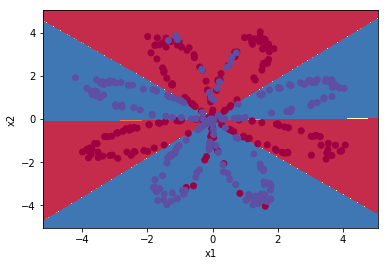

In [63]:
# 好，所有函数都实现完毕了，我们已经构建好了一个浅层神经网络了。
# 现在用这个浅层神经网络来执行与文章开头的单神经元网络同样的任务——将花形图案中的红蓝点区分开

# 首先是根据训练数据来进行参数学习（训练数据是与单神经元网络一样一样的）
parameters = nn_model(X, Y, n_h = 4, num_iterations=10000, print_cost=True)

# 然后用训练得出的参数进行预测。
predictions = predict(parameters, X)
print ('预测准确率是: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

# 将预测结果画出来。
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y.ravel())

从上面的结果可以看出，准确率达到了90%，从画出的图形也可以看出，基本上都区分对了。

单神经元网络时才47%，这个进步是相当大的。

在这个2层的浅层神经网络中，隐藏层我们只用了4个神经元，其实如果神经元更多些，预测结果会更准确一些。

当然也不少越多越准确，具体应该多少个神经元合适，在以后的文章中我会教大家的。

下面提供了一段代码，分别对比了当隐藏层神经元个数不同时，预测结果的准确度。

i = 0 cost = 0.6931475438458983
i = 1 cost = 0.6931260414004419
i = 2 cost = 0.6931022386237693
i = 3 cost = 0.6930711641263824
i = 4 cost = 0.6930268970353882
i = 5 cost = 0.6929615251682535
i = 6 cost = 0.6928639934720578
i = 7 cost = 0.6927188611434311
i = 8 cost = 0.6925052270466929
i = 9 cost = 0.692196525498914
i = 10 cost = 0.6917625254605116
i = 11 cost = 0.69117528401761
i = 12 cost = 0.69041985024809
i = 13 cost = 0.6895067429235964
i = 14 cost = 0.6884777044440733
i = 15 cost = 0.6873955121602296
i = 16 cost = 0.6863188351923175
i = 17 cost = 0.6852765387155286
i = 18 cost = 0.6842562912089707
i = 19 cost = 0.6832102805489376
i = 20 cost = 0.6820724444474853
i = 21 cost = 0.6807824121557977
i = 22 cost = 0.6793109909198413
i = 23 cost = 0.6776743486224275
i = 24 cost = 0.6759244789784847
i = 25 cost = 0.6741250943746354
i = 26 cost = 0.6723343893833402
i = 27 cost = 0.6705993916042491
i = 28 cost = 0.6689546090603774
i = 29 cost = 0.6674218675224356
i = 30 cost = 0.666011583

i = 560 cost = 0.6384451535012658
i = 561 cost = 0.6384391428403394
i = 562 cost = 0.6384331454842979
i = 563 cost = 0.6384271613791107
i = 564 cost = 0.6384211904710724
i = 565 cost = 0.6384152327068002
i = 566 cost = 0.638409288033233
i = 567 cost = 0.6384033563976267
i = 568 cost = 0.6383974377475526
i = 569 cost = 0.6383915320308957
i = 570 cost = 0.6383856391958505
i = 571 cost = 0.6383797591909199
i = 572 cost = 0.6383738919649125
i = 573 cost = 0.6383680374669393
i = 574 cost = 0.6383621956464128
i = 575 cost = 0.6383563664530436
i = 576 cost = 0.6383505498368379
i = 577 cost = 0.6383447457480963
i = 578 cost = 0.63833895413741
i = 579 cost = 0.6383331749556601
i = 580 cost = 0.6383274081540141
i = 581 cost = 0.6383216536839238
i = 582 cost = 0.6383159114971244
i = 583 cost = 0.6383101815456304
i = 584 cost = 0.6383044637817348
i = 585 cost = 0.6382987581580065
i = 586 cost = 0.6382930646272882
i = 587 cost = 0.6382873831426941
i = 588 cost = 0.6382817136576082
i = 589 cost = 0.

i = 1060 cost = 0.6364511901218975
i = 1061 cost = 0.6364484648256863
i = 1062 cost = 0.636445742731364
i = 1063 cost = 0.6364430238322528
i = 1064 cost = 0.6364403081216942
i = 1065 cost = 0.6364375955930499
i = 1066 cost = 0.6364348862397021
i = 1067 cost = 0.6364321800550519
i = 1068 cost = 0.6364294770325211
i = 1069 cost = 0.6364267771655507
i = 1070 cost = 0.6364240804476017
i = 1071 cost = 0.6364213868721545
i = 1072 cost = 0.6364186964327089
i = 1073 cost = 0.6364160091227844
i = 1074 cost = 0.6364133249359195
i = 1075 cost = 0.6364106438656725
i = 1076 cost = 0.6364079659056202
i = 1077 cost = 0.636405291049359
i = 1078 cost = 0.6364026192905042
i = 1079 cost = 0.6363999506226902
i = 1080 cost = 0.6363972850395698
i = 1081 cost = 0.6363946225348155
i = 1082 cost = 0.6363919631021178
i = 1083 cost = 0.6363893067351859
i = 1084 cost = 0.636386653427748
i = 1085 cost = 0.6363840031735508
i = 1086 cost = 0.636381355966359
i = 1087 cost = 0.636378711799956
i = 1088 cost = 0.6363760

i = 1695 cost = 0.6351718466073496
i = 1696 cost = 0.6351703348433625
i = 1697 cost = 0.6351688242048641
i = 1698 cost = 0.6351673146903655
i = 1699 cost = 0.6351658062983809
i = 1700 cost = 0.6351642990274274
i = 1701 cost = 0.6351627928760247
i = 1702 cost = 0.6351612878426952
i = 1703 cost = 0.6351597839259644
i = 1704 cost = 0.6351582811243603
i = 1705 cost = 0.6351567794364139
i = 1706 cost = 0.6351552788606588
i = 1707 cost = 0.6351537793956313
i = 1708 cost = 0.6351522810398709
i = 1709 cost = 0.6351507837919192
i = 1710 cost = 0.6351492876503211
i = 1711 cost = 0.6351477926136238
i = 1712 cost = 0.6351462986803774
i = 1713 cost = 0.635144805849135
i = 1714 cost = 0.6351433141184519
i = 1715 cost = 0.6351418234868865
i = 1716 cost = 0.6351403339529998
i = 1717 cost = 0.6351388455153554
i = 1718 cost = 0.6351373581725197
i = 1719 cost = 0.6351358719230616
i = 1720 cost = 0.635134386765553
i = 1721 cost = 0.6351329026985681
i = 1722 cost = 0.635131419720684
i = 1723 cost = 0.63512

i = 2254 cost = 0.6344681103112317
i = 2255 cost = 0.6344670562208631
i = 2256 cost = 0.6344660027226251
i = 2257 cost = 0.6344649498159245
i = 2258 cost = 0.6344638975001685
i = 2259 cost = 0.6344628457747653
i = 2260 cost = 0.6344617946391241
i = 2261 cost = 0.6344607440926546
i = 2262 cost = 0.6344596941347679
i = 2263 cost = 0.6344586447648753
i = 2264 cost = 0.6344575959823894
i = 2265 cost = 0.6344565477867234
i = 2266 cost = 0.6344555001772918
i = 2267 cost = 0.6344544531535091
i = 2268 cost = 0.6344534067147914
i = 2269 cost = 0.6344523608605552
i = 2270 cost = 0.6344513155902183
i = 2271 cost = 0.6344502709031984
i = 2272 cost = 0.6344492267989154
i = 2273 cost = 0.6344481832767886
i = 2274 cost = 0.6344471403362393
i = 2275 cost = 0.6344460979766889
i = 2276 cost = 0.63444505619756
i = 2277 cost = 0.6344440149982756
i = 2278 cost = 0.6344429743782602
i = 2279 cost = 0.6344419343369385
i = 2280 cost = 0.6344408948737363
i = 2281 cost = 0.6344398559880802
i = 2282 cost = 0.6344

i = 2862 cost = 0.633918295291717
i = 2863 cost = 0.6339175164856539
i = 2864 cost = 0.6339167380244564
i = 2865 cost = 0.6339159599078519
i = 2866 cost = 0.6339151821355676
i = 2867 cost = 0.6339144047073318
i = 2868 cost = 0.6339136276228727
i = 2869 cost = 0.6339128508819186
i = 2870 cost = 0.6339120744841983
i = 2871 cost = 0.6339112984294409
i = 2872 cost = 0.6339105227173761
i = 2873 cost = 0.6339097473477335
i = 2874 cost = 0.633908972320243
i = 2875 cost = 0.6339081976346351
i = 2876 cost = 0.6339074232906405
i = 2877 cost = 0.6339066492879901
i = 2878 cost = 0.6339058756264153
i = 2879 cost = 0.6339051023056474
i = 2880 cost = 0.6339043293254185
i = 2881 cost = 0.6339035566854608
i = 2882 cost = 0.6339027843855068
i = 2883 cost = 0.6339020124252892
i = 2884 cost = 0.633901240804541
i = 2885 cost = 0.633900469522996
i = 2886 cost = 0.6338996985803874
i = 2887 cost = 0.6338989279764495
i = 2888 cost = 0.6338981577109165
i = 2889 cost = 0.6338973877835232
i = 2890 cost = 0.633896

i = 3444 cost = 0.6335156790633935
i = 3445 cost = 0.633515063223257
i = 3446 cost = 0.6335144476099447
i = 3447 cost = 0.633513832223308
i = 3448 cost = 0.6335132170631981
i = 3449 cost = 0.6335126021294664
i = 3450 cost = 0.6335119874219644
i = 3451 cost = 0.6335113729405438
i = 3452 cost = 0.6335107586850566
i = 3453 cost = 0.6335101446553545
i = 3454 cost = 0.63350953085129
i = 3455 cost = 0.6335089172727152
i = 3456 cost = 0.6335083039194823
i = 3457 cost = 0.6335076907914441
i = 3458 cost = 0.6335070778884533
i = 3459 cost = 0.6335064652103625
i = 3460 cost = 0.6335058527570248
i = 3461 cost = 0.6335052405282934
i = 3462 cost = 0.6335046285240213
i = 3463 cost = 0.6335040167440622
i = 3464 cost = 0.6335034051882693
i = 3465 cost = 0.6335027938564965
i = 3466 cost = 0.6335021827485974
i = 3467 cost = 0.6335015718644261
i = 3468 cost = 0.6335009612038366
i = 3469 cost = 0.6335003507666831
i = 3470 cost = 0.63349974055282
i = 3471 cost = 0.6334991305621017
i = 3472 cost = 0.63349852

i = 4047 cost = 0.6331807559096446
i = 4048 cost = 0.6331802541600793
i = 4049 cost = 0.6331797525680669
i = 4050 cost = 0.6331792511335195
i = 4051 cost = 0.6331787498563495
i = 4052 cost = 0.6331782487364691
i = 4053 cost = 0.6331777477737909
i = 4054 cost = 0.6331772469682272
i = 4055 cost = 0.6331767463196908
i = 4056 cost = 0.6331762458280943
i = 4057 cost = 0.6331757454933503
i = 4058 cost = 0.6331752453153716
i = 4059 cost = 0.633174745294071
i = 4060 cost = 0.6331742454293616
i = 4061 cost = 0.6331737457211564
i = 4062 cost = 0.6331732461693682
i = 4063 cost = 0.6331727467739102
i = 4064 cost = 0.6331722475346958
i = 4065 cost = 0.6331717484516382
i = 4066 cost = 0.6331712495246508
i = 4067 cost = 0.6331707507536467
i = 4068 cost = 0.6331702521385396
i = 4069 cost = 0.6331697536792431
i = 4070 cost = 0.6331692553756709
i = 4071 cost = 0.6331687572277364
i = 4072 cost = 0.6331682592353534
i = 4073 cost = 0.633167761398436
i = 4074 cost = 0.6331672637168979
i = 4075 cost = 0.6331

i = 4656 cost = 0.6329014277497658
i = 4657 cost = 0.6329010079869445
i = 4658 cost = 0.6329005883390028
i = 4659 cost = 0.6329001688058848
i = 4660 cost = 0.6328997493875355
i = 4661 cost = 0.6328993300838991
i = 4662 cost = 0.6328989108949201
i = 4663 cost = 0.6328984918205435
i = 4664 cost = 0.6328980728607138
i = 4665 cost = 0.6328976540153755
i = 4666 cost = 0.6328972352844735
i = 4667 cost = 0.6328968166679528
i = 4668 cost = 0.632896398165758
i = 4669 cost = 0.632895979777834
i = 4670 cost = 0.6328955615041256
i = 4671 cost = 0.6328951433445781
i = 4672 cost = 0.6328947252991362
i = 4673 cost = 0.6328943073677448
i = 4674 cost = 0.6328938895503491
i = 4675 cost = 0.6328934718468944
i = 4676 cost = 0.6328930542573253
i = 4677 cost = 0.6328926367815875
i = 4678 cost = 0.632892219419626
i = 4679 cost = 0.6328918021713861
i = 4680 cost = 0.632891385036813
i = 4681 cost = 0.6328909680158522
i = 4682 cost = 0.6328905511084487
i = 4683 cost = 0.6328901343145483
i = 4684 cost = 0.632889

1个隐藏层神经元时的准确度是: 67.5 %
i = 0 cost = 0.6931162485343116
i = 1 cost = 0.6930795579994777
i = 2 cost = 0.6930320365106419
i = 3 cost = 0.6929645975999423
i = 4 cost = 0.6928651712317441
i = 5 cost = 0.6927169506150677
i = 6 cost = 0.6924965335118688
i = 7 cost = 0.6921723871918678
i = 8 cost = 0.691704774054757
i = 9 cost = 0.691049267320015
i = 10 cost = 0.690166595050965
i = 11 cost = 0.6890399186039856
i = 12 cost = 0.6876945924116501
i = 13 cost = 0.6862069124538093
i = 14 cost = 0.6846876714189648
i = 15 cost = 0.683242721101752
i = 16 cost = 0.6819342609081894
i = 17 cost = 0.680767689268321
i = 18 cost = 0.6797073016234227
i = 19 cost = 0.6787044325859136
i = 20 cost = 0.677719515405237
i = 21 cost = 0.676728903372496
i = 22 cost = 0.6757181445121592
i = 23 cost = 0.6746705871957023
i = 24 cost = 0.6735596388705011
i = 25 cost = 0.6723459725434776
i = 26 cost = 0.6709760872411349
i = 27 cost = 0.6693804165437248
i = 28 cost = 0.6674748305100431
i = 29 cost = 0.6651753290344012
i = 

i = 651 cost = 0.5848635962620986
i = 652 cost = 0.5848538636240158
i = 653 cost = 0.584844150648855
i = 654 cost = 0.5848344572683163
i = 655 cost = 0.5848247834144432
i = 656 cost = 0.58481512901962
i = 657 cost = 0.5848054940165694
i = 658 cost = 0.5847958783383506
i = 659 cost = 0.5847862819183567
i = 660 cost = 0.5847767046903128
i = 661 cost = 0.5847671465882736
i = 662 cost = 0.5847576075466211
i = 663 cost = 0.5847480875000631
i = 664 cost = 0.5847385863836303
i = 665 cost = 0.5847291041326742
i = 666 cost = 0.5847196406828656
i = 667 cost = 0.5847101959701922
i = 668 cost = 0.584700769930956
i = 669 cost = 0.5846913625017724
i = 670 cost = 0.5846819736195669
i = 671 cost = 0.584672603221574
i = 672 cost = 0.5846632512453347
i = 673 cost = 0.5846539176286947
i = 674 cost = 0.5846446023098024
i = 675 cost = 0.5846353052271069
i = 676 cost = 0.5846260263193562
i = 677 cost = 0.584616765525595
i = 678 cost = 0.5846075227851631
i = 679 cost = 0.5845982980376931
i = 680 cost = 0.584

i = 1462 cost = 0.5803728267988961
i = 1463 cost = 0.5803695471972267
i = 1464 cost = 0.5803662706341953
i = 1465 cost = 0.5803629971048254
i = 1466 cost = 0.5803597266041508
i = 1467 cost = 0.580356459127217
i = 1468 cost = 0.5803531946690803
i = 1469 cost = 0.5803499332248079
i = 1470 cost = 0.5803466747894782
i = 1471 cost = 0.5803434193581805
i = 1472 cost = 0.5803401669260146
i = 1473 cost = 0.580336917488092
i = 1474 cost = 0.5803336710395345
i = 1475 cost = 0.5803304275754747
i = 1476 cost = 0.5803271870910562
i = 1477 cost = 0.5803239495814332
i = 1478 cost = 0.5803207150417709
i = 1479 cost = 0.5803174834672445
i = 1480 cost = 0.5803142548530411
i = 1481 cost = 0.5803110291943573
i = 1482 cost = 0.5803078064864009
i = 1483 cost = 0.58030458672439
i = 1484 cost = 0.5803013699035534
i = 1485 cost = 0.5802981560191305
i = 1486 cost = 0.5802949450663708
i = 1487 cost = 0.5802917370405348
i = 1488 cost = 0.5802885319368932
i = 1489 cost = 0.5802853297507269
i = 1490 cost = 0.580282

i = 1988 cost = 0.5789742969871077
i = 1989 cost = 0.5789721232412223
i = 1990 cost = 0.5789699509284173
i = 1991 cost = 0.5789677800468983
i = 1992 cost = 0.5789656105948734
i = 1993 cost = 0.5789634425705537
i = 1994 cost = 0.5789612759721535
i = 1995 cost = 0.5789591107978901
i = 1996 cost = 0.5789569470459839
i = 1997 cost = 0.5789547847146582
i = 1998 cost = 0.5789526238021393
i = 1999 cost = 0.5789504643066565
i = 2000 cost = 0.5789483062264424
i = 2001 cost = 0.5789461495597323
i = 2002 cost = 0.5789439943047645
i = 2003 cost = 0.5789418404597801
i = 2004 cost = 0.5789396880230239
i = 2005 cost = 0.5789375369927428
i = 2006 cost = 0.5789353873671871
i = 2007 cost = 0.57893323914461
i = 2008 cost = 0.5789310923232676
i = 2009 cost = 0.5789289469014192
i = 2010 cost = 0.5789268028773266
i = 2011 cost = 0.5789246602492547
i = 2012 cost = 0.5789225190154716
i = 2013 cost = 0.578920379174248
i = 2014 cost = 0.5789182407238576
i = 2015 cost = 0.578916103662577
i = 2016 cost = 0.578913

i = 2334 cost = 0.5782969944462445
i = 2335 cost = 0.5782952270732719
i = 2336 cost = 0.5782934606582499
i = 2337 cost = 0.5782916952001433
i = 2338 cost = 0.5782899306979182
i = 2339 cost = 0.5782881671505422
i = 2340 cost = 0.5782864045569844
i = 2341 cost = 0.578284642916216
i = 2342 cost = 0.5782828822272087
i = 2343 cost = 0.5782811224889367
i = 2344 cost = 0.5782793637003751
i = 2345 cost = 0.5782776058605009
i = 2346 cost = 0.5782758489682923
i = 2347 cost = 0.5782740930227294
i = 2348 cost = 0.5782723380227934
i = 2349 cost = 0.5782705839674672
i = 2350 cost = 0.5782688308557354
i = 2351 cost = 0.5782670786865838
i = 2352 cost = 0.5782653274589997
i = 2353 cost = 0.5782635771719721
i = 2354 cost = 0.5782618278244915
i = 2355 cost = 0.5782600794155498
i = 2356 cost = 0.5782583319441401
i = 2357 cost = 0.5782565854092577
i = 2358 cost = 0.5782548398098988
i = 2359 cost = 0.5782530951450611
i = 2360 cost = 0.5782513514137441
i = 2361 cost = 0.5782496086149486
i = 2362 cost = 0.578

i = 2669 cost = 0.5777527952921945
i = 2670 cost = 0.5777512992020242
i = 2671 cost = 0.5777498037943005
i = 2672 cost = 0.5777483090683778
i = 2673 cost = 0.5777468150236109
i = 2674 cost = 0.5777453216593557
i = 2675 cost = 0.5777438289749687
i = 2676 cost = 0.5777423369698076
i = 2677 cost = 0.5777408456432309
i = 2678 cost = 0.5777393549945977
i = 2679 cost = 0.5777378650232683
i = 2680 cost = 0.5777363757286033
i = 2681 cost = 0.5777348871099649
i = 2682 cost = 0.5777333991667155
i = 2683 cost = 0.5777319118982186
i = 2684 cost = 0.5777304253038388
i = 2685 cost = 0.577728939382941
i = 2686 cost = 0.5777274541348915
i = 2687 cost = 0.577725969559057
i = 2688 cost = 0.5777244856548053
i = 2689 cost = 0.5777230024215049
i = 2690 cost = 0.5777215198585252
i = 2691 cost = 0.5777200379652364
i = 2692 cost = 0.5777185567410097
i = 2693 cost = 0.5777170761852168
i = 2694 cost = 0.5777155962972306
i = 2695 cost = 0.5777141170764246
i = 2696 cost = 0.5777126385221731
i = 2697 cost = 0.5777

i = 3183 cost = 0.5770613643758129
i = 3184 cost = 0.5770601498839925
i = 3185 cost = 0.577058935830677
i = 3186 cost = 0.5770577222155242
i = 3187 cost = 0.5770565090381922
i = 3188 cost = 0.5770552962983393
i = 3189 cost = 0.5770540839956246
i = 3190 cost = 0.5770528721297074
i = 3191 cost = 0.5770516607002469
i = 3192 cost = 0.5770504497069037
i = 3193 cost = 0.5770492391493377
i = 3194 cost = 0.57704802902721
i = 3195 cost = 0.5770468193401818
i = 3196 cost = 0.5770456100879146
i = 3197 cost = 0.5770444012700703
i = 3198 cost = 0.5770431928863115
i = 3199 cost = 0.5770419849363005
i = 3200 cost = 0.577040777419701
i = 3201 cost = 0.577039570336176
i = 3202 cost = 0.5770383636853897
i = 3203 cost = 0.5770371574670061
i = 3204 cost = 0.5770359516806901
i = 3205 cost = 0.5770347463261065
i = 3206 cost = 0.577033541402921
i = 3207 cost = 0.5770323369107991
i = 3208 cost = 0.5770311328494071
i = 3209 cost = 0.5770299292184116
i = 3210 cost = 0.5770287260174796
i = 3211 cost = 0.57702752

i = 3777 cost = 0.5764070076182454
i = 3778 cost = 0.5764060045141569
i = 3779 cost = 0.5764050016986285
i = 3780 cost = 0.5764039991714771
i = 3781 cost = 0.5764029969325196
i = 3782 cost = 0.5764019949815736
i = 3783 cost = 0.576400993318456
i = 3784 cost = 0.5763999919429845
i = 3785 cost = 0.576398990854977
i = 3786 cost = 0.5763979900542514
i = 3787 cost = 0.5763969895406256
i = 3788 cost = 0.5763959893139179
i = 3789 cost = 0.5763949893739467
i = 3790 cost = 0.5763939897205309
i = 3791 cost = 0.576392990353489
i = 3792 cost = 0.57639199127264
i = 3793 cost = 0.5763909924778031
i = 3794 cost = 0.5763899939687976
i = 3795 cost = 0.576388995745443
i = 3796 cost = 0.5763879978075589
i = 3797 cost = 0.5763870001549651
i = 3798 cost = 0.5763860027874819
i = 3799 cost = 0.5763850057049291
i = 3800 cost = 0.5763840089071272
i = 3801 cost = 0.5763830123938968
i = 3802 cost = 0.5763820161650585
i = 3803 cost = 0.5763810202204331
i = 3804 cost = 0.5763800245598418
i = 3805 cost = 0.57637902

i = 4503 cost = 0.5757447891922519
i = 4504 cost = 0.5757439565649051
i = 4505 cost = 0.5757431241288351
i = 4506 cost = 0.5757422918839454
i = 4507 cost = 0.5757414598301392
i = 4508 cost = 0.5757406279673204
i = 4509 cost = 0.5757397962953924
i = 4510 cost = 0.5757389648142591
i = 4511 cost = 0.5757381335238242
i = 4512 cost = 0.5757373024239917
i = 4513 cost = 0.5757364715146653
i = 4514 cost = 0.5757356407957492
i = 4515 cost = 0.5757348102671478
i = 4516 cost = 0.5757339799287646
i = 4517 cost = 0.5757331497805045
i = 4518 cost = 0.5757323198222716
i = 4519 cost = 0.5757314900539703
i = 4520 cost = 0.575730660475505
i = 4521 cost = 0.5757298310867806
i = 4522 cost = 0.5757290018877014
i = 4523 cost = 0.5757281728781721
i = 4524 cost = 0.575727344058098
i = 4525 cost = 0.5757265154273834
i = 4526 cost = 0.5757256869859336
i = 4527 cost = 0.5757248587336533
i = 4528 cost = 0.5757240306704481
i = 4529 cost = 0.5757232027962226
i = 4530 cost = 0.5757223751108825
i = 4531 cost = 0.5757

2个隐藏层神经元时的准确度是: 67.25 %
i = 0 cost = 0.6931142222248914
i = 1 cost = 0.6930802746281955
i = 2 cost = 0.6930353990610741
i = 3 cost = 0.6929711813549843
i = 4 cost = 0.6928763724727648
i = 5 cost = 0.692735420119111
i = 6 cost = 0.6925270765288128
i = 7 cost = 0.6922236523276698
i = 8 cost = 0.6917921412357706
i = 9 cost = 0.6911990591507492
i = 10 cost = 0.6904204034265462
i = 11 cost = 0.6894549671675443
i = 12 cost = 0.6883333499534916
i = 13 cost = 0.6871120557480077
i = 14 cost = 0.6858502684971739
i = 15 cost = 0.6845823137109411
i = 16 cost = 0.6833036878133771
i = 17 cost = 0.681977293183121
i = 18 cost = 0.6805543162817207
i = 19 cost = 0.6790002168253302
i = 20 cost = 0.6773139671587844
i = 21 cost = 0.675527441972464
i = 22 cost = 0.6736843303186418
i = 23 cost = 0.671816854925928
i = 24 cost = 0.669935547566136
i = 25 cost = 0.6680298413757706
i = 26 cost = 0.6660723663340636
i = 27 cost = 0.6640245065775465
i = 28 cost = 0.661843761735703
i = 29 cost = 0.6594937574285639
i 

i = 704 cost = 0.292422543276258
i = 705 cost = 0.29239306403607235
i = 706 cost = 0.2923636414718953
i = 707 cost = 0.2923342753625916
i = 708 cost = 0.2923049654882852
i = 709 cost = 0.2922757116303503
i = 710 cost = 0.2922465135714024
i = 711 cost = 0.2922173710952887
i = 712 cost = 0.2921882839870797
i = 713 cost = 0.29215925203305937
i = 714 cost = 0.29213027502071737
i = 715 cost = 0.2921013527387396
i = 716 cost = 0.2920724849769996
i = 717 cost = 0.2920436715265502
i = 718 cost = 0.2920149121796146
i = 719 cost = 0.2919862067295782
i = 720 cost = 0.2919575549709801
i = 721 cost = 0.29192895669950475
i = 722 cost = 0.2919004117119738
i = 723 cost = 0.29187191980633787
i = 724 cost = 0.2918434807816685
i = 725 cost = 0.29181509443814996
i = 726 cost = 0.2917867605770716
i = 727 cost = 0.29175847900081964
i = 728 cost = 0.29173024951286963
i = 729 cost = 0.29170207191777847
i = 730 cost = 0.2916739460211768
i = 731 cost = 0.2916458716297614
i = 732 cost = 0.29161784855128786
i = 7

i = 1426 cost = 0.278994070753743
i = 1427 cost = 0.2789815288788275
i = 1428 cost = 0.27896899684221244
i = 1429 cost = 0.2789564746288228
i = 1430 cost = 0.2789439622236214
i = 1431 cost = 0.2789314596116087
i = 1432 cost = 0.2789189667778228
i = 1433 cost = 0.2789064837073392
i = 1434 cost = 0.27889401038527084
i = 1435 cost = 0.2788815467967677
i = 1436 cost = 0.2788690929270168
i = 1437 cost = 0.27885664876124233
i = 1438 cost = 0.2788442142847052
i = 1439 cost = 0.27883178948270293
i = 1440 cost = 0.27881937434056975
i = 1441 cost = 0.27880696884367623
i = 1442 cost = 0.2787945729774294
i = 1443 cost = 0.27878218672727234
i = 1444 cost = 0.2787698100786844
i = 1445 cost = 0.2787574430171808
i = 1446 cost = 0.27874508552831273
i = 1447 cost = 0.2787327375976669
i = 1448 cost = 0.27872039921086583
i = 1449 cost = 0.2787080703535674
i = 1450 cost = 0.27869575101146504
i = 1451 cost = 0.27868344117028726
i = 1452 cost = 0.27867114081579786
i = 1453 cost = 0.2786588499337956
i = 1454 

i = 2175 cost = 0.2716330426973773
i = 2176 cost = 0.2716252609657029
i = 2177 cost = 0.27161748341549286
i = 2178 cost = 0.2716097100430861
i = 2179 cost = 0.2716019408448268
i = 2180 cost = 0.2715941758170642
i = 2181 cost = 0.27158641495615266
i = 2182 cost = 0.27157865825845173
i = 2183 cost = 0.27157090572032605
i = 2184 cost = 0.2715631573381454
i = 2185 cost = 0.27155541310828457
i = 2186 cost = 0.27154767302712357
i = 2187 cost = 0.2715399370910474
i = 2188 cost = 0.2715322052964462
i = 2189 cost = 0.27152447763971493
i = 2190 cost = 0.2715167541172539
i = 2191 cost = 0.2715090347254683
i = 2192 cost = 0.2715013194607683
i = 2193 cost = 0.27149360831956926
i = 2194 cost = 0.27148590129829137
i = 2195 cost = 0.27147819839335996
i = 2196 cost = 0.27147049960120506
i = 2197 cost = 0.271462804918262
i = 2198 cost = 0.271455114340971
i = 2199 cost = 0.2714474278657771
i = 2200 cost = 0.2714397454891303
i = 2201 cost = 0.27143206720748564
i = 2202 cost = 0.27142439301730303
i = 2203 

i = 2899 cost = 0.2669081463534102
i = 2900 cost = 0.26690267095870607
i = 2901 cost = 0.266897197992199
i = 2902 cost = 0.2668917274522918
i = 2903 cost = 0.26688625933738885
i = 2904 cost = 0.266880793645896
i = 2905 cost = 0.26687533037622074
i = 2906 cost = 0.26686986952677183
i = 2907 cost = 0.2668644110959596
i = 2908 cost = 0.2668589550821961
i = 2909 cost = 0.2668535014838946
i = 2910 cost = 0.26684805029947
i = 2911 cost = 0.2668426015273387
i = 2912 cost = 0.26683715516591844
i = 2913 cost = 0.26683171121362875
i = 2914 cost = 0.26682626966889034
i = 2915 cost = 0.2668208305301257
i = 2916 cost = 0.2668153937957584
i = 2917 cost = 0.26680995946421393
i = 2918 cost = 0.266804527533919
i = 2919 cost = 0.26679909800330187
i = 2920 cost = 0.2667936708707922
i = 2921 cost = 0.2667882461348213
i = 2922 cost = 0.2667828237938219
i = 2923 cost = 0.26677740384622795
i = 2924 cost = 0.2667719862904752
i = 2925 cost = 0.2667665711250007
i = 2926 cost = 0.2667611583482431
i = 2927 cost =

i = 3432 cost = 0.26429834436994953
i = 3433 cost = 0.2642939689358958
i = 3434 cost = 0.2642895952514216
i = 3435 cost = 0.264285223315516
i = 3436 cost = 0.26428085312716904
i = 3437 cost = 0.2642764846853713
i = 3438 cost = 0.2642721179891144
i = 3439 cost = 0.2642677530373906
i = 3440 cost = 0.26426338982919295
i = 3441 cost = 0.26425902836351545
i = 3442 cost = 0.26425466863935276
i = 3443 cost = 0.26425031065570026
i = 3444 cost = 0.26424595441155424
i = 3445 cost = 0.26424159990591173
i = 3446 cost = 0.2642372471377707
i = 3447 cost = 0.2642328961061295
i = 3448 cost = 0.2642285468099877
i = 3449 cost = 0.26422419924834545
i = 3450 cost = 0.26421985342020365
i = 3451 cost = 0.26421550932456406
i = 3452 cost = 0.26421116696042923
i = 3453 cost = 0.26420682632680237
i = 3454 cost = 0.2642024874226876
i = 3455 cost = 0.26419815024708987
i = 3456 cost = 0.2641938147990146
i = 3457 cost = 0.2641894810774684
i = 3458 cost = 0.2641851490814583
i = 3459 cost = 0.26418081880999233
i = 34

i = 4122 cost = 0.2616465650255699
i = 4123 cost = 0.2616431931311044
i = 4124 cost = 0.26163982244026324
i = 4125 cost = 0.26163645295243204
i = 4126 cost = 0.261633084666997
i = 4127 cost = 0.26162971758334447
i = 4128 cost = 0.2616263517008614
i = 4129 cost = 0.2616229870189351
i = 4130 cost = 0.2616196235369532
i = 4131 cost = 0.2616162612543039
i = 4132 cost = 0.26161290017037575
i = 4133 cost = 0.2616095402845576
i = 4134 cost = 0.2616061815962387
i = 4135 cost = 0.261602824104809
i = 4136 cost = 0.2615994678096586
i = 4137 cost = 0.261596112710178
i = 4138 cost = 0.2615927588057582
i = 4139 cost = 0.2615894060957906
i = 4140 cost = 0.26158605457966694
i = 4141 cost = 0.2615827042567794
i = 4142 cost = 0.26157935512652064
i = 4143 cost = 0.2615760071882835
i = 4144 cost = 0.2615726604414616
i = 4145 cost = 0.26156931488544866
i = 4146 cost = 0.26156597051963887
i = 4147 cost = 0.26156262734342683
i = 4148 cost = 0.26155928535620754
i = 4149 cost = 0.2615559445573765
i = 4150 cost

i = 4782 cost = 0.2596564581002952
i = 4783 cost = 0.25965376417449393
i = 4784 cost = 0.2596510711219353
i = 4785 cost = 0.25964837894221476
i = 4786 cost = 0.2596456876349274
i = 4787 cost = 0.25964299719966893
i = 4788 cost = 0.2596403076360353
i = 4789 cost = 0.2596376189436225
i = 4790 cost = 0.2596349311220269
i = 4791 cost = 0.25963224417084513
i = 4792 cost = 0.2596295580896739
i = 4793 cost = 0.25962687287811037
i = 4794 cost = 0.25962418853575187
i = 4795 cost = 0.2596215050621959
i = 4796 cost = 0.25961882245704027
i = 4797 cost = 0.2596161407198829
i = 4798 cost = 0.2596134598503223
i = 4799 cost = 0.2596107798479568
i = 4800 cost = 0.25960810071238516
i = 4801 cost = 0.25960542244320645
i = 4802 cost = 0.2596027450400198
i = 4803 cost = 0.25960006850242473
i = 4804 cost = 0.2595973928300209
i = 4805 cost = 0.25959471802240836
i = 4806 cost = 0.25959204407918723
i = 4807 cost = 0.2595893709999579
i = 4808 cost = 0.2595866987843211
i = 4809 cost = 0.2595840274318777
i = 4810

i = 650 cost = 0.2980624230490145
i = 651 cost = 0.2980253602935463
i = 652 cost = 0.29798837147441
i = 653 cost = 0.29795145625035935
i = 654 cost = 0.2979146142824199
i = 655 cost = 0.2978778452338701
i = 656 cost = 0.2978411487702231
i = 657 cost = 0.29780452455920875
i = 658 cost = 0.29776797227075585
i = 659 cost = 0.2977314915769743
i = 660 cost = 0.2976950821521378
i = 661 cost = 0.2976587436726662
i = 662 cost = 0.2976224758171086
i = 663 cost = 0.29758627826612616
i = 664 cost = 0.2975501507024755
i = 665 cost = 0.2975140928109917
i = 666 cost = 0.2974781042785721
i = 667 cost = 0.2974421847941597
i = 668 cost = 0.29740633404872724
i = 669 cost = 0.29737055173526084
i = 670 cost = 0.29733483754874435
i = 671 cost = 0.2972991911861437
i = 672 cost = 0.29726361234639087
i = 673 cost = 0.2972281007303691
i = 674 cost = 0.2971926560408972
i = 675 cost = 0.2971572779827143
i = 676 cost = 0.2971219662624654
i = 677 cost = 0.2970867205886858
i = 678 cost = 0.2970515406717872
i = 679 

i = 1305 cost = 0.28207144743641555
i = 1306 cost = 0.2820541391766545
i = 1307 cost = 0.2820368431287153
i = 1308 cost = 0.2820195592565076
i = 1309 cost = 0.28200228752385553
i = 1310 cost = 0.2819850278944967
i = 1311 cost = 0.2819677803320804
i = 1312 cost = 0.281950544800167
i = 1313 cost = 0.28193332126222637
i = 1314 cost = 0.28191610968163666
i = 1315 cost = 0.28189891002168327
i = 1316 cost = 0.2818817222455571
i = 1317 cost = 0.28186454631635394
i = 1318 cost = 0.2818473821970726
i = 1319 cost = 0.2818302298506141
i = 1320 cost = 0.28181308923978005
i = 1321 cost = 0.28179596032727133
i = 1322 cost = 0.28177884307568707
i = 1323 cost = 0.28176173744752325
i = 1324 cost = 0.28174464340517114
i = 1325 cost = 0.28172756091091605
i = 1326 cost = 0.2817104899269364
i = 1327 cost = 0.2816934304153017
i = 1328 cost = 0.28167638233797176
i = 1329 cost = 0.28165934565679496
i = 1330 cost = 0.28164232033350706
i = 1331 cost = 0.2816253063297298
i = 1332 cost = 0.2816083036069694
i = 13

i = 1892 cost = 0.27067921279698676
i = 1893 cost = 0.270627470143593
i = 1894 cost = 0.2705744738839343
i = 1895 cost = 0.27052015581361655
i = 1896 cost = 0.2704644434612999
i = 1897 cost = 0.27040725983157077
i = 1898 cost = 0.2703485231401282
i = 1899 cost = 0.2702881465432841
i = 1900 cost = 0.270226037864449
i = 1901 cost = 0.27016209932107915
i = 1902 cost = 0.2700962272565229
i = 1903 cost = 0.27002831188233306
i = 1904 cost = 0.2699582370379273
i = 1905 cost = 0.26988587997598734
i = 1906 cost = 0.26981111118368517
i = 1907 cost = 0.26973379425170735
i = 1908 cost = 0.2696537858050684
i = 1909 cost = 0.2695709355118143
i = 1910 cost = 0.2694850861878095
i = 1911 cost = 0.2693960740177308
i = 1912 cost = 0.26930372891395943
i = 1913 cost = 0.2692078750359821
i = 1914 cost = 0.26910833149283947
i = 1915 cost = 0.26900491324964987
i = 1916 cost = 0.26889743225578383
i = 1917 cost = 0.2687856988063127
i = 1918 cost = 0.2686695231393348
i = 1919 cost = 0.2685487172592179
i = 1920 c

i = 2499 cost = 0.24048140085269218
i = 2500 cost = 0.2404638106576063
i = 2501 cost = 0.24044624472833678
i = 2502 cost = 0.24042870300872798
i = 2503 cost = 0.24041118544279938
i = 2504 cost = 0.24039369197474503
i = 2505 cost = 0.2403762225489328
i = 2506 cost = 0.24035877710990342
i = 2507 cost = 0.24034135560237024
i = 2508 cost = 0.24032395797121825
i = 2509 cost = 0.2403065841615033
i = 2510 cost = 0.24028923411845163
i = 2511 cost = 0.2402719077874592
i = 2512 cost = 0.2402546051140908
i = 2513 cost = 0.24023732604407946
i = 2514 cost = 0.24022007052332606
i = 2515 cost = 0.24020283849789806
i = 2516 cost = 0.24018562991402953
i = 2517 cost = 0.24016844471811996
i = 2518 cost = 0.24015128285673382
i = 2519 cost = 0.24013414427659988
i = 2520 cost = 0.24011702892461068
i = 2521 cost = 0.2400999367478215
i = 2522 cost = 0.24008286769345033
i = 2523 cost = 0.2400658217088765
i = 2524 cost = 0.24004879874164073
i = 2525 cost = 0.240031798739444
i = 2526 cost = 0.24001482165014715
i

i = 3234 cost = 0.23173743129948027
i = 3235 cost = 0.23172918653148286
i = 3236 cost = 0.23172094812680588
i = 3237 cost = 0.23171271607628918
i = 3238 cost = 0.23170449037079066
i = 3239 cost = 0.23169627100118675
i = 3240 cost = 0.23168805795837208
i = 3241 cost = 0.23167985123325963
i = 3242 cost = 0.23167165081678046
i = 3243 cost = 0.23166345669988392
i = 3244 cost = 0.23165526887353735
i = 3245 cost = 0.2316470873287263
i = 3246 cost = 0.23163891205645412
i = 3247 cost = 0.23163074304774248
i = 3248 cost = 0.23162258029363061
i = 3249 cost = 0.2316144237851759
i = 3250 cost = 0.23160627351345348
i = 3251 cost = 0.23159812946955632
i = 3252 cost = 0.2315899916445951
i = 3253 cost = 0.2315818600296983
i = 3254 cost = 0.23157373461601197
i = 3255 cost = 0.23156561539469983
i = 3256 cost = 0.23155750235694328
i = 3257 cost = 0.23154939549394107
i = 3258 cost = 0.2315412947969097
i = 3259 cost = 0.23153320025708282
i = 3260 cost = 0.23152511186571179
i = 3261 cost = 0.231517029614065

i = 3910 cost = 0.22726500465195493
i = 3911 cost = 0.2272596327736303
i = 3912 cost = 0.22725426371046897
i = 3913 cost = 0.2272488974596335
i = 3914 cost = 0.22724353401829048
i = 3915 cost = 0.22723817338361096
i = 3916 cost = 0.22723281555276997
i = 3917 cost = 0.22722746052294682
i = 3918 cost = 0.22722210829132514
i = 3919 cost = 0.2272167588550926
i = 3920 cost = 0.22721141221144114
i = 3921 cost = 0.2272060683575669
i = 3922 cost = 0.22720072729067006
i = 3923 cost = 0.22719538900795513
i = 3924 cost = 0.22719005350663057
i = 3925 cost = 0.22718472078390925
i = 3926 cost = 0.2271793908370079
i = 3927 cost = 0.22717406366314757
i = 3928 cost = 0.22716873925955333
i = 3929 cost = 0.22716341762345457
i = 3930 cost = 0.2271580987520844
i = 3931 cost = 0.2271527826426803
i = 3932 cost = 0.2271474692924839
i = 3933 cost = 0.22714215869874063
i = 3934 cost = 0.22713685085870025
i = 3935 cost = 0.22713154576961656
i = 3936 cost = 0.22712624342874727
i = 3937 cost = 0.22712094383335427


i = 4615 cost = 0.22404546042149817
i = 4616 cost = 0.2240415525611711
i = 4617 cost = 0.22403764623087574
i = 4618 cost = 0.22403374142947008
i = 4619 cost = 0.2240298381558133
i = 4620 cost = 0.22402593640876578
i = 4621 cost = 0.22402203618718922
i = 4622 cost = 0.22401813748994637
i = 4623 cost = 0.22401424031590164
i = 4624 cost = 0.22401034466392034
i = 4625 cost = 0.2240064505328691
i = 4626 cost = 0.22400255792161597
i = 4627 cost = 0.2239986668290301
i = 4628 cost = 0.22399477725398184
i = 4629 cost = 0.22399088919534296
i = 4630 cost = 0.22398700265198626
i = 4631 cost = 0.22398311762278603
i = 4632 cost = 0.22397923410661755
i = 4633 cost = 0.22397535210235744
i = 4634 cost = 0.2239714716088836
i = 4635 cost = 0.22396759262507512
i = 4636 cost = 0.22396371514981234
i = 4637 cost = 0.2239598391819767
i = 4638 cost = 0.2239559647204512
i = 4639 cost = 0.2239520917641196
i = 4640 cost = 0.22394822031186729
i = 4641 cost = 0.22394435036258062
i = 4642 cost = 0.22394048191514734


4个隐藏层神经元时的准确度是: 90.5 %
i = 0 cost = 0.6932523197920643
i = 1 cost = 0.6931953244267598
i = 2 cost = 0.6931554689243609
i = 3 cost = 0.6931219645783281
i = 4 cost = 0.693086671838051
i = 5 cost = 0.693042038409859
i = 6 cost = 0.6929794476077576
i = 7 cost = 0.6928876386254131
i = 8 cost = 0.6927509940316157
i = 9 cost = 0.6925476558841294
i = 10 cost = 0.6922477332162296
i = 11 cost = 0.6918124270373437
i = 12 cost = 0.6911957753110317
i = 13 cost = 0.6903515675976286
i = 14 cost = 0.6892475548559185
i = 15 cost = 0.6878853626835965
i = 16 cost = 0.6863172518054816
i = 17 cost = 0.6846457947689335
i = 18 cost = 0.6829989178861011
i = 19 cost = 0.6814898544019516
i = 20 cost = 0.6801838555701303
i = 21 cost = 0.6790887626921865
i = 22 cost = 0.6781697784060057
i = 23 cost = 0.6773746110236983
i = 24 cost = 0.6766534222159349
i = 25 cost = 0.6759662791830173
i = 26 cost = 0.6752801463052088
i = 27 cost = 0.6745622410811133
i = 28 cost = 0.6737760606375002
i = 29 cost = 0.6728823268710928

i = 457 cost = 0.29987958468672354
i = 458 cost = 0.2998282577916352
i = 459 cost = 0.29977710297244814
i = 460 cost = 0.29972611909109487
i = 461 cost = 0.29967530501969913
i = 462 cost = 0.2996246596404653
i = 463 cost = 0.2995741818455693
i = 464 cost = 0.29952387053705004
i = 465 cost = 0.29947372462670363
i = 466 cost = 0.2994237430359774
i = 467 cost = 0.2993739246958667
i = 468 cost = 0.29932426854681166
i = 469 cost = 0.2992747735385964
i = 470 cost = 0.2992254386302486
i = 471 cost = 0.299176262789941
i = 472 cost = 0.29912724499489385
i = 473 cost = 0.2990783842312783
i = 474 cost = 0.29902967949412135
i = 475 cost = 0.2989811297872123
i = 476 cost = 0.2989327341230093
i = 477 cost = 0.29888449152254815
i = 478 cost = 0.2988364010153517
i = 479 cost = 0.29878846163934036
i = 480 cost = 0.298740672440744
i = 481 cost = 0.2986930324740142
i = 482 cost = 0.29864554080173894
i = 483 cost = 0.2985981964945568
i = 484 cost = 0.29855099863107326
i = 485 cost = 0.2985039462977774
i =

i = 1038 cost = 0.28305713887492084
i = 1039 cost = 0.2830387214195493
i = 1040 cost = 0.28302032244793
i = 1041 cost = 0.28300194191997774
i = 1042 cost = 0.28298357979575606
i = 1043 cost = 0.28296523603547696
i = 1044 cost = 0.28294691059949995
i = 1045 cost = 0.28292860344833154
i = 1046 cost = 0.28291031454262433
i = 1047 cost = 0.2828920438431764
i = 1048 cost = 0.28287379131093077
i = 1049 cost = 0.28285555690697434
i = 1050 cost = 0.2828373405925375
i = 1051 cost = 0.28281914232899336
i = 1052 cost = 0.28280096207785704
i = 1053 cost = 0.282782799800785
i = 1054 cost = 0.2827646554595745
i = 1055 cost = 0.2827465290161625
i = 1056 cost = 0.2827284204326256
i = 1057 cost = 0.2827103296711788
i = 1058 cost = 0.2826922566941755
i = 1059 cost = 0.28267420146410616
i = 1060 cost = 0.2826561639435979
i = 1061 cost = 0.28263814409541405
i = 1062 cost = 0.2826201418824533
i = 1063 cost = 0.2826021572677492
i = 1064 cost = 0.2825841902144693
i = 1065 cost = 0.2825662406859147
i = 1066 c

i = 1599 cost = 0.27485055207108855
i = 1600 cost = 0.2748387899193388
i = 1601 cost = 0.2748270356775406
i = 1602 cost = 0.2748152893370126
i = 1603 cost = 0.27480355088908903
i = 1604 cost = 0.27479182032511923
i = 1605 cost = 0.27478009763646793
i = 1606 cost = 0.2747683828145149
i = 1607 cost = 0.2747566758506549
i = 1608 cost = 0.27474497673629783
i = 1609 cost = 0.27473328546286874
i = 1610 cost = 0.2747216020218073
i = 1611 cost = 0.2747099264045684
i = 1612 cost = 0.2746982586026216
i = 1613 cost = 0.27468659860745115
i = 1614 cost = 0.2746749464105563
i = 1615 cost = 0.2746633020034507
i = 1616 cost = 0.27465166537766295
i = 1617 cost = 0.27464003652473606
i = 1618 cost = 0.2746284154362275
i = 1619 cost = 0.2746168021037094
i = 1620 cost = 0.27460519651876825
i = 1621 cost = 0.274593598673005
i = 1622 cost = 0.27458200855803466
i = 1623 cost = 0.2745704261654871
i = 1624 cost = 0.2745588514870059
i = 1625 cost = 0.274547284514249
i = 1626 cost = 0.27453572523888864
i = 1627 c

i = 2143 cost = 0.2694295645641613
i = 2144 cost = 0.2694211083393321
i = 2145 cost = 0.26941265673474585
i = 2146 cost = 0.26940420974612445
i = 2147 cost = 0.2693957673691942
i = 2148 cost = 0.26938732959968603
i = 2149 cost = 0.26937889643333557
i = 2150 cost = 0.2693704678658828
i = 2151 cost = 0.2693620438930726
i = 2152 cost = 0.26935362451065414
i = 2153 cost = 0.2693452097143812
i = 2154 cost = 0.2693367995000122
i = 2155 cost = 0.26932839386331003
i = 2156 cost = 0.2693199928000422
i = 2157 cost = 0.26931159630598045
i = 2158 cost = 0.2693032043769016
i = 2159 cost = 0.2692948170085863
i = 2160 cost = 0.2692864341968203
i = 2161 cost = 0.2692780559373936
i = 2162 cost = 0.2692696822261007
i = 2163 cost = 0.2692613130587405
i = 2164 cost = 0.2692529484311165
i = 2165 cost = 0.2692445883390367
i = 2166 cost = 0.2692362327783135
i = 2167 cost = 0.26922788174476375
i = 2168 cost = 0.2692195352342088
i = 2169 cost = 0.2692111932424744
i = 2170 cost = 0.2692028557653909
i = 2171 cos

i = 2860 cost = 0.2643312690730212
i = 2861 cost = 0.26432524252950196
i = 2862 cost = 0.2643192183584018
i = 2863 cost = 0.26431319655729313
i = 2864 cost = 0.2643071771237494
i = 2865 cost = 0.264301160055345
i = 2866 cost = 0.26429514534965526
i = 2867 cost = 0.26428913300425644
i = 2868 cost = 0.26428312301672546
i = 2869 cost = 0.2642771153846406
i = 2870 cost = 0.26427111010558063
i = 2871 cost = 0.26426510717712554
i = 2872 cost = 0.26425910659685586
i = 2873 cost = 0.2642531083623534
i = 2874 cost = 0.2642471124712006
i = 2875 cost = 0.26424111892098084
i = 2876 cost = 0.2642351277092785
i = 2877 cost = 0.26422913883367877
i = 2878 cost = 0.2642231522917676
i = 2879 cost = 0.26421716808113205
i = 2880 cost = 0.2642111861993598
i = 2881 cost = 0.26420520664403957
i = 2882 cost = 0.26419922941276097
i = 2883 cost = 0.2641932545031143
i = 2884 cost = 0.26418728191269086
i = 2885 cost = 0.26418131163908276
i = 2886 cost = 0.26417534367988293
i = 2887 cost = 0.26416937803268525
i = 

i = 3351 cost = 0.2616116496043198
i = 3352 cost = 0.26160650852196604
i = 3353 cost = 0.26160136869352296
i = 3354 cost = 0.26159623011686833
i = 3355 cost = 0.26159109278988085
i = 3356 cost = 0.2615859567104403
i = 3357 cost = 0.26158082187642767
i = 3358 cost = 0.26157568828572497
i = 3359 cost = 0.2615705559362153
i = 3360 cost = 0.26156542482578293
i = 3361 cost = 0.26156029495231325
i = 3362 cost = 0.26155516631369263
i = 3363 cost = 0.2615500389078088
i = 3364 cost = 0.2615449127325506
i = 3365 cost = 0.26153978778580783
i = 3366 cost = 0.26153466406547154
i = 3367 cost = 0.2615295415694339
i = 3368 cost = 0.2615244202955884
i = 3369 cost = 0.26151930024182957
i = 3370 cost = 0.26151418140605304
i = 3371 cost = 0.2615090637861557
i = 3372 cost = 0.26150394738003563
i = 3373 cost = 0.26149883218559217
i = 3374 cost = 0.2614937182007257
i = 3375 cost = 0.2614886054233379
i = 3376 cost = 0.2614834938513317
i = 3377 cost = 0.2614783834826111
i = 3378 cost = 0.26147327431508144
i = 

i = 3993 cost = 0.25848758205122624
i = 3994 cost = 0.25848287999242286
i = 3995 cost = 0.2584781780892523
i = 3996 cost = 0.2584734763395209
i = 3997 cost = 0.2584687747410287
i = 3998 cost = 0.2584640732915687
i = 3999 cost = 0.25845937198892716
i = 4000 cost = 0.25845467083088386
i = 4001 cost = 0.2584499698152117
i = 4002 cost = 0.258445268939677
i = 4003 cost = 0.2584405682020393
i = 4004 cost = 0.25843586760005144
i = 4005 cost = 0.25843116713145975
i = 4006 cost = 0.2584264667940036
i = 4007 cost = 0.25842176658541605
i = 4008 cost = 0.25841706650342333
i = 4009 cost = 0.25841236654574506
i = 4010 cost = 0.2584076667100943
i = 4011 cost = 0.2584029669941774
i = 4012 cost = 0.2583982673956943
i = 4013 cost = 0.2583935679123382
i = 4014 cost = 0.25838886854179577
i = 4015 cost = 0.25838416928174723
i = 4016 cost = 0.25837947012986623
i = 4017 cost = 0.25837477108381995
i = 4018 cost = 0.258370072141269
i = 4019 cost = 0.2583653732998677
i = 4020 cost = 0.25836067455726364
i = 4021

i = 4665 cost = 0.2551765324278314
i = 4666 cost = 0.2551708234179347
i = 4667 cost = 0.2551651084974129
i = 4668 cost = 0.25515938762750345
i = 4669 cost = 0.25515366076911633
i = 4670 cost = 0.25514792788283147
i = 4671 cost = 0.25514218892889473
i = 4672 cost = 0.25513644386721557
i = 4673 cost = 0.2551306926573625
i = 4674 cost = 0.25512493525856
i = 4675 cost = 0.2551191716296848
i = 4676 cost = 0.2551134017292617
i = 4677 cost = 0.25510762551545996
i = 4678 cost = 0.25510184294608884
i = 4679 cost = 0.25509605397859353
i = 4680 cost = 0.2550902585700505
i = 4681 cost = 0.2550844566771633
i = 4682 cost = 0.25507864825625753
i = 4683 cost = 0.25507283326327596
i = 4684 cost = 0.25506701165377366
i = 4685 cost = 0.25506118338291267
i = 4686 cost = 0.25505534840545674
i = 4687 cost = 0.25504950667576554
i = 4688 cost = 0.2550436581477891
i = 4689 cost = 0.2550378027750621
i = 4690 cost = 0.255031940510697
i = 4691 cost = 0.25502607130737864
i = 4692 cost = 0.25502019511735724
i = 469

5个隐藏层神经元时的准确度是: 91.25 %
i = 0 cost = 0.6931354078572382
i = 1 cost = 0.692936721444014
i = 2 cost = 0.6927156451706034
i = 3 cost = 0.6924285167706146
i = 4 cost = 0.6920262786712297
i = 5 cost = 0.691449302797051
i = 6 cost = 0.6906261653920245
i = 7 cost = 0.6894801958514669
i = 8 cost = 0.6879497625814557
i = 9 cost = 0.6860262232533952
i = 10 cost = 0.6838004634228517
i = 11 cost = 0.6814841259202495
i = 12 cost = 0.6793602737546521
i = 13 cost = 0.6776643391437801
i = 14 cost = 0.6764798459667858
i = 15 cost = 0.6757373264422535
i = 16 cost = 0.6752982570194632
i = 17 cost = 0.6750358242479109
i = 18 cost = 0.6748659594564523
i = 19 cost = 0.6747423737293334
i = 20 cost = 0.6746419656584061
i = 21 cost = 0.6745534287599544
i = 22 cost = 0.6744708672132851
i = 23 cost = 0.674390748513577
i = 24 cost = 0.6743105550953729
i = 25 cost = 0.674228190601361
i = 26 cost = 0.6741416967365242
i = 27 cost = 0.6740490930093525
i = 28 cost = 0.6739482644222289
i = 29 cost = 0.6738368678016883


i = 298 cost = 0.30741790787454876
i = 299 cost = 0.3073053172401729
i = 300 cost = 0.30719336880811127
i = 301 cost = 0.30708205210983974
i = 302 cost = 0.30697135682730947
i = 303 cost = 0.30686127279078435
i = 304 cost = 0.30675178997677427
i = 305 cost = 0.30664289850606263
i = 306 cost = 0.30653458864182703
i = 307 cost = 0.3064268507878516
i = 308 cost = 0.30631967548682904
i = 309 cost = 0.306213053418752
i = 310 cost = 0.3061069753993911
i = 311 cost = 0.30600143237885985
i = 312 cost = 0.3058964154402637
i = 313 cost = 0.3057919157984332
i = 314 cost = 0.3056879247987397
i = 315 cost = 0.3055844339159918
i = 316 cost = 0.30548143475341205
i = 317 cost = 0.30537891904169245
i = 318 cost = 0.30527687863812747
i = 319 cost = 0.3051753055258228
i = 320 cost = 0.3050741918129803
i = 321 cost = 0.30497352973225506
i = 322 cost = 0.3048733116401857
i = 323 cost = 0.3047735300166952
i = 324 cost = 0.3046741774646607
i = 325 cost = 0.3045752467095511
i = 326 cost = 0.30447673059913183


i = 603 cost = 0.28693991344151293
i = 604 cost = 0.2869030655021666
i = 605 cost = 0.28686631936993234
i = 606 cost = 0.28682967438789503
i = 607 cost = 0.28679312990568145
i = 608 cost = 0.28675668527937775
i = 609 cost = 0.28672033987144724
i = 610 cost = 0.2866840930506488
i = 611 cost = 0.2866479441919569
i = 612 cost = 0.2866118926764819
i = 613 cost = 0.2865759378913913
i = 614 cost = 0.2865400792298322
i = 615 cost = 0.286504316090854
i = 616 cost = 0.2864686478793329
i = 617 cost = 0.28643307400589657
i = 618 cost = 0.2863975938868498
i = 619 cost = 0.28636220694410136
i = 620 cost = 0.28632691260509135
i = 621 cost = 0.2862917103027198
i = 622 cost = 0.28625659947527593
i = 623 cost = 0.28622157956636823
i = 624 cost = 0.28618665002485566
i = 625 cost = 0.2861518103047795
i = 626 cost = 0.2861170598652961
i = 627 cost = 0.2860823981706108
i = 628 cost = 0.28604782468991197
i = 629 cost = 0.2860133388973069
i = 630 cost = 0.28597894027175763
i = 631 cost = 0.28594462829701817


i = 912 cost = 0.2785202284200085
i = 913 cost = 0.27849870971916346
i = 914 cost = 0.27847720789412117
i = 915 cost = 0.27845572271914226
i = 916 cost = 0.27843425396638743
i = 917 cost = 0.2784128014058634
i = 918 cost = 0.27839136480536747
i = 919 cost = 0.27836994393043185
i = 920 cost = 0.27834853854426506
i = 921 cost = 0.2783271484076938
i = 922 cost = 0.27830577327910205
i = 923 cost = 0.27828441291437017
i = 924 cost = 0.27826306706681114
i = 925 cost = 0.27824173548710646
i = 926 cost = 0.27822041792324015
i = 927 cost = 0.27819911412043147
i = 928 cost = 0.27817782382106543
i = 929 cost = 0.2781565467646228
i = 930 cost = 0.2781352826876075
i = 931 cost = 0.27811403132347257
i = 932 cost = 0.2780927924025448
i = 933 cost = 0.2780715656519473
i = 934 cost = 0.27805035079551965
i = 935 cost = 0.2780291475537376
i = 936 cost = 0.27800795564362957
i = 937 cost = 0.27798677477869144
i = 938 cost = 0.27796560466879955
i = 939 cost = 0.277944445020122
i = 940 cost = 0.2779232955350

i = 1295 cost = 0.2521295184964431
i = 1296 cost = 0.2519801114601476
i = 1297 cost = 0.25183154829717536
i = 1298 cost = 0.25168383637784963
i = 1299 cost = 0.2515369824801161
i = 1300 cost = 0.2513909927992923
i = 1301 cost = 0.25124587295825435
i = 1302 cost = 0.2511016280180291
i = 1303 cost = 0.2509582624887595
i = 1304 cost = 0.2508157803410142
i = 1305 cost = 0.25067418501740746
i = 1306 cost = 0.25053347944450133
i = 1307 cost = 0.2503936660449593
i = 1308 cost = 0.2502547467499223
i = 1309 cost = 0.2501167230115782
i = 1310 cost = 0.24997959581589715
i = 1311 cost = 0.24984336569550533
i = 1312 cost = 0.24970803274267092
i = 1313 cost = 0.24957359662237655
i = 1314 cost = 0.24944005658545368
i = 1315 cost = 0.24930741148175473
i = 1316 cost = 0.24917565977334064
i = 1317 cost = 0.2490447995476616
i = 1318 cost = 0.2489148285307098
i = 1319 cost = 0.24878574410012455
i = 1320 cost = 0.24865754329823075
i = 1321 cost = 0.2485302228449923
i = 1322 cost = 0.24840377915086345
i = 1

i = 1589 cost = 0.2260628476658983
i = 1590 cost = 0.2259489614615357
i = 1591 cost = 0.2258360740358416
i = 1592 cost = 0.22572420960005318
i = 1593 cost = 0.22561338457420377
i = 1594 cost = 0.22550360835712463
i = 1595 cost = 0.2253948841107004
i = 1596 cost = 0.2252872095372116
i = 1597 cost = 0.2251805776326849
i = 1598 cost = 0.22507497740310498
i = 1599 cost = 0.2249703945339519
i = 1600 cost = 0.2248668120067267
i = 1601 cost = 0.22476421065886004
i = 1602 cost = 0.22466256968565104
i = 1603 cost = 0.22456186708468798
i = 1604 cost = 0.22446208004457774
i = 1605 cost = 0.22436318528082397
i = 1606 cost = 0.2242651593223842
i = 1607 cost = 0.2241679787528649
i = 1608 cost = 0.22407162041052878
i = 1609 cost = 0.22397606155133695
i = 1610 cost = 0.22388127997917123
i = 1611 cost = 0.2237872541472104
i = 1612 cost = 0.22369396323420304
i = 1613 cost = 0.22360138719910463
i = 1614 cost = 0.22350950681725165
i = 1615 cost = 0.22341830370094407
i = 1616 cost = 0.22332776030700502
i =

i = 1902 cost = 0.20791025370686533
i = 1903 cost = 0.20787106614195786
i = 1904 cost = 0.2078319224767815
i = 1905 cost = 0.20779282257607845
i = 1906 cost = 0.20775376630698553
i = 1907 cost = 0.20771475353899727
i = 1908 cost = 0.20767578414392973
i = 1909 cost = 0.20763685799588388
i = 1910 cost = 0.20759797497121085
i = 1911 cost = 0.20755913494847605
i = 1912 cost = 0.20752033780842483
i = 1913 cost = 0.20748158343394826
i = 1914 cost = 0.20744287171004913
i = 1915 cost = 0.20740420252380873
i = 1916 cost = 0.20736557576435374
i = 1917 cost = 0.20732699132282356
i = 1918 cost = 0.20728844909233857
i = 1919 cost = 0.20724994896796775
i = 1920 cost = 0.2072114908466979
i = 1921 cost = 0.20717307462740223
i = 1922 cost = 0.20713470021081
i = 1923 cost = 0.20709636749947624
i = 1924 cost = 0.20705807639775195
i = 1925 cost = 0.20701982681175457
i = 1926 cost = 0.20698161864933906
i = 1927 cost = 0.20694345182006885
i = 1928 cost = 0.20690532623518793
i = 1929 cost = 0.206867241807592

i = 2190 cost = 0.19821968147058797
i = 2191 cost = 0.19819122818810073
i = 2192 cost = 0.19816280832473573
i = 2193 cost = 0.19813442184575983
i = 2194 cost = 0.19810606871631428
i = 2195 cost = 0.19807774890141558
i = 2196 cost = 0.1980494623659565
i = 2197 cost = 0.1980212090747068
i = 2198 cost = 0.19799298899231432
i = 2199 cost = 0.19796480208330586
i = 2200 cost = 0.19793664831208804
i = 2201 cost = 0.19790852764294825
i = 2202 cost = 0.19788044004005567
i = 2203 cost = 0.19785238546746192
i = 2204 cost = 0.1978243638891025
i = 2205 cost = 0.19779637526879693
i = 2206 cost = 0.19776841957025065
i = 2207 cost = 0.19774049675705518
i = 2208 cost = 0.19771260679268962
i = 2209 cost = 0.19768474964052096
i = 2210 cost = 0.1976569252638058
i = 2211 cost = 0.19762913362569065
i = 2212 cost = 0.19760137468921332
i = 2213 cost = 0.19757364841730365
i = 2214 cost = 0.19754595477278433
i = 2215 cost = 0.19751829371837226
i = 2216 cost = 0.19749066521667927
i = 2217 cost = 0.19746306923021

i = 2466 cost = 0.19149627467757616
i = 2467 cost = 0.1914754979787569
i = 2468 cost = 0.19145474321879757
i = 2469 cost = 0.19143401035652555
i = 2470 cost = 0.19141329935079335
i = 2471 cost = 0.19139261016047798
i = 2472 cost = 0.1913719427444816
i = 2473 cost = 0.19135129706173054
i = 2474 cost = 0.19133067307117568
i = 2475 cost = 0.1913100707317921
i = 2476 cost = 0.19128949000257886
i = 2477 cost = 0.191268930842559
i = 2478 cost = 0.19124839321077908
i = 2479 cost = 0.19122787706630937
i = 2480 cost = 0.19120738236824317
i = 2481 cost = 0.1911869090756973
i = 2482 cost = 0.19116645714781103
i = 2483 cost = 0.1911460265437467
i = 2484 cost = 0.191125617222689
i = 2485 cost = 0.1911052291438449
i = 2486 cost = 0.1910848622664435
i = 2487 cost = 0.19106451654973566
i = 2488 cost = 0.19104419195299394
i = 2489 cost = 0.19102388843551213
i = 2490 cost = 0.1910036059566054
i = 2491 cost = 0.1909833444756096
i = 2492 cost = 0.19096310395188137
i = 2493 cost = 0.19094288434479761
i = 2

i = 2744 cost = 0.1864217452462686
i = 2745 cost = 0.18640550744589496
i = 2746 cost = 0.18638928027201399
i = 2747 cost = 0.18637306368445944
i = 2748 cost = 0.18635685764311993
i = 2749 cost = 0.18634066210793981
i = 2750 cost = 0.1863244770389207
i = 2751 cost = 0.1863083023961231
i = 2752 cost = 0.18629213813966772
i = 2753 cost = 0.18627598422973698
i = 2754 cost = 0.18625984062657686
i = 2755 cost = 0.18624370729049794
i = 2756 cost = 0.18622758418187746
i = 2757 cost = 0.18621147126116064
i = 2758 cost = 0.18619536848886234
i = 2759 cost = 0.18617927582556884
i = 2760 cost = 0.18616319323193956
i = 2761 cost = 0.1861471206687085
i = 2762 cost = 0.18613105809668615
i = 2763 cost = 0.1861150054767613
i = 2764 cost = 0.1860989627699027
i = 2765 cost = 0.18608292993716105
i = 2766 cost = 0.18606690693967068
i = 2767 cost = 0.1860508937386513
i = 2768 cost = 0.18603489029541037
i = 2769 cost = 0.18601889657134454
i = 2770 cost = 0.18600291252794177
i = 2771 cost = 0.1859869381267834


i = 3005 cost = 0.18246065940309505
i = 3006 cost = 0.18244645956270802
i = 3007 cost = 0.18243226853274663
i = 3008 cost = 0.18241808634395093
i = 3009 cost = 0.1824039130269994
i = 3010 cost = 0.1823897486125029
i = 3011 cost = 0.18237559313099935
i = 3012 cost = 0.18236144661294829
i = 3013 cost = 0.18234730908872485
i = 3014 cost = 0.18233318058861514
i = 3015 cost = 0.18231906114281046
i = 3016 cost = 0.18230495078140244
i = 3017 cost = 0.1822908495343778
i = 3018 cost = 0.18227675743161365
i = 3019 cost = 0.1822626745028721
i = 3020 cost = 0.1822486007777962
i = 3021 cost = 0.18223453628590455
i = 3022 cost = 0.18222048105658717
i = 3023 cost = 0.18220643511910098
i = 3024 cost = 0.1821923985025652
i = 3025 cost = 0.1821783712359572
i = 3026 cost = 0.18216435334810846
i = 3027 cost = 0.18215034486770001
i = 3028 cost = 0.1821363458232592
i = 3029 cost = 0.1821223562431549
i = 3030 cost = 0.18210837615559444
i = 3031 cost = 0.18209440558861945
i = 3032 cost = 0.18208044457010256
i

i = 3261 cost = 0.1791655824362997
i = 3262 cost = 0.17915411566950237
i = 3263 cost = 0.1791426594164639
i = 3264 cost = 0.17913121366491944
i = 3265 cost = 0.17911977840254495
i = 3266 cost = 0.17910835361695832
i = 3267 cost = 0.1790969392957204
i = 3268 cost = 0.17908553542633585
i = 3269 cost = 0.17907414199625393
i = 3270 cost = 0.1790627589928696
i = 3271 cost = 0.17905138640352408
i = 3272 cost = 0.17904002421550622
i = 3273 cost = 0.179028672416053
i = 3274 cost = 0.17901733099235068
i = 3275 cost = 0.17900599993153535
i = 3276 cost = 0.17899467922069426
i = 3277 cost = 0.17898336884686636
i = 3278 cost = 0.17897206879704305
i = 3279 cost = 0.17896077905816948
i = 3280 cost = 0.17894949961714515
i = 3281 cost = 0.17893823046082466
i = 3282 cost = 0.17892697157601858
i = 3283 cost = 0.17891572294949462
i = 3284 cost = 0.17890448456797792
i = 3285 cost = 0.1788932564181524
i = 3286 cost = 0.17888203848666123
i = 3287 cost = 0.17887083076010768
i = 3288 cost = 0.1788596332250562


i = 3540 cost = 0.1763248014739033
i = 3541 cost = 0.17631573661146654
i = 3542 cost = 0.17630667856045734
i = 3543 cost = 0.17629762730987253
i = 3544 cost = 0.17628858284872956
i = 3545 cost = 0.17627954516606614
i = 3546 cost = 0.17627051425094045
i = 3547 cost = 0.1762614900924312
i = 3548 cost = 0.17625247267963726
i = 3549 cost = 0.17624346200167784
i = 3550 cost = 0.1762344580476924
i = 3551 cost = 0.17622546080684054
i = 3552 cost = 0.17621647026830195
i = 3553 cost = 0.1762074864212765
i = 3554 cost = 0.17619850925498415
i = 3555 cost = 0.1761895387586644
i = 3556 cost = 0.17618057492157724
i = 3557 cost = 0.1761716177330021
i = 3558 cost = 0.17616266718223847
i = 3559 cost = 0.17615372325860548
i = 3560 cost = 0.17614478595144217
i = 3561 cost = 0.1761358552501069
i = 3562 cost = 0.176126931143978
i = 3563 cost = 0.17611801362245313
i = 3564 cost = 0.17610910267494959
i = 3565 cost = 0.176100198290904
i = 3566 cost = 0.1760913004597726
i = 3567 cost = 0.1760824091710308
i = 3

i = 3800 cost = 0.1741687904649073
i = 3801 cost = 0.17416117716216523
i = 3802 cost = 0.17415356837924498
i = 3803 cost = 0.1741459641092397
i = 3804 cost = 0.17413836434525615
i = 3805 cost = 0.1741307690804151
i = 3806 cost = 0.1741231783078512
i = 3807 cost = 0.17411559202071294
i = 3808 cost = 0.17410801021216252
i = 3809 cost = 0.17410043287537633
i = 3810 cost = 0.1740928600035445
i = 3811 cost = 0.17408529158987107
i = 3812 cost = 0.17407772762757412
i = 3813 cost = 0.17407016810988551
i = 3814 cost = 0.1740626130300511
i = 3815 cost = 0.17405506238133078
i = 3816 cost = 0.1740475161569983
i = 3817 cost = 0.17403997435034135
i = 3818 cost = 0.1740324369546618
i = 3819 cost = 0.1740249039632753
i = 3820 cost = 0.1740173753695116
i = 3821 cost = 0.1740098511667144
i = 3822 cost = 0.1740023313482416
i = 3823 cost = 0.17399481590746496
i = 3824 cost = 0.1739873048377703
i = 3825 cost = 0.17397979813255762
i = 3826 cost = 0.17397229578524087
i = 3827 cost = 0.17396479778924814
i = 3

i = 4099 cost = 0.17206803608578616
i = 4100 cost = 0.17206153052410728
i = 4101 cost = 0.1720550280585332
i = 4102 cost = 0.17204852868618473
i = 4103 cost = 0.1720420324041892
i = 4104 cost = 0.1720355392096809
i = 4105 cost = 0.17202904909980055
i = 4106 cost = 0.1720225620716955
i = 4107 cost = 0.17201607812251965
i = 4108 cost = 0.17200959724943293
i = 4109 cost = 0.17200311944960184
i = 4110 cost = 0.17199664472019896
i = 4111 cost = 0.17199017305840292
i = 4112 cost = 0.17198370446139846
i = 4113 cost = 0.17197723892637604
i = 4114 cost = 0.1719707764505321
i = 4115 cost = 0.17196431703106874
i = 4116 cost = 0.17195786066519378
i = 4117 cost = 0.17195140735012054
i = 4118 cost = 0.17194495708306778
i = 4119 cost = 0.17193850986125978
i = 4120 cost = 0.17193206568192593
i = 4121 cost = 0.17192562454230098
i = 4122 cost = 0.17191918643962473
i = 4123 cost = 0.17191275137114212
i = 4124 cost = 0.17190631933410283
i = 4125 cost = 0.17189989032576172
i = 4126 cost = 0.171893464343378

i = 4371 cost = 0.17040377659318903
i = 4372 cost = 0.17039801560293302
i = 4373 cost = 0.17039225699791383
i = 4374 cost = 0.17038650077564466
i = 4375 cost = 0.17038074693364116
i = 4376 cost = 0.1703749954694215
i = 4377 cost = 0.1703692463805063
i = 4378 cost = 0.17036349966441888
i = 4379 cost = 0.17035775531868516
i = 4380 cost = 0.17035201334083347
i = 4381 cost = 0.17034627372839495
i = 4382 cost = 0.17034053647890332
i = 4383 cost = 0.17033480158989497
i = 4384 cost = 0.17032906905890907
i = 4385 cost = 0.17032333888348739
i = 4386 cost = 0.1703176110611743
i = 4387 cost = 0.17031188558951726
i = 4388 cost = 0.17030616246606628
i = 4389 cost = 0.17030044168837422
i = 4390 cost = 0.17029472325399664
i = 4391 cost = 0.17028900716049208
i = 4392 cost = 0.17028329340542192
i = 4393 cost = 0.17027758198635026
i = 4394 cost = 0.17027187290084428
i = 4395 cost = 0.1702661661464739
i = 4396 cost = 0.17026046172081205
i = 4397 cost = 0.17025475962143452
i = 4398 cost = 0.17024905984592

i = 4713 cost = 0.16855814641293201
i = 4714 cost = 0.16855311780379334
i = 4715 cost = 0.16854809925028336
i = 4716 cost = 0.16854309272574255
i = 4717 cost = 0.16853810009343945
i = 4718 cost = 0.16853312431143624
i = 4719 cost = 0.16852816803667936
i = 4720 cost = 0.1685232357233746
i = 4721 cost = 0.16851833113622458
i = 4722 cost = 0.16851346101621992
i = 4723 cost = 0.168508630652149
i = 4724 cost = 0.16850385030314408
i = 4725 cost = 0.16849912731238997
i = 4726 cost = 0.16849447739001241
i = 4727 cost = 0.16848991056544904
i = 4728 cost = 0.1684854510588901
i = 4729 cost = 0.16848111224696438
i = 4730 cost = 0.16847693174270423
i = 4731 cost = 0.1684729267543594
i = 4732 cost = 0.16846915614859842
i = 4733 cost = 0.1684656407896925
i = 4734 cost = 0.1684624735603233
i = 4735 cost = 0.16845967710244772
i = 4736 cost = 0.1684573992026656
i = 4737 cost = 0.16845565855947053
i = 4738 cost = 0.16845469230294635
i = 4739 cost = 0.16845450136965165
i = 4740 cost = 0.16845546937664685


20个隐藏层神经元时的准确度是: 90.5 %
i = 0 cost = 0.6932236819242581
i = 1 cost = 0.6926373840346423
i = 2 cost = 0.6920220006331198
i = 3 cost = 0.6912613630867406
i = 4 cost = 0.6902474367244354
i = 5 cost = 0.6888798947860528
i = 6 cost = 0.6870877694221471
i = 7 cost = 0.6848751804608015
i = 8 cost = 0.6823761797035928
i = 9 cost = 0.6798703028956683
i = 10 cost = 0.6776995605029412
i = 11 cost = 0.6761037908386168
i = 12 cost = 0.6751085295334552
i = 13 cost = 0.6745694691007609
i = 14 cost = 0.6743028845757751
i = 15 cost = 0.6741725531726462
i = 16 cost = 0.6741027456282029
i = 17 cost = 0.6740582240520859
i = 18 cost = 0.6740242443390911
i = 19 cost = 0.6739949467713403
i = 20 cost = 0.6739680043136116
i = 21 cost = 0.6739424376074149
i = 22 cost = 0.6739177780231996
i = 23 cost = 0.6738937554286806
i = 24 cost = 0.6738701811788225
i = 25 cost = 0.6738469025763177
i = 26 cost = 0.6738237837044417
i = 27 cost = 0.6738006963063604
i = 28 cost = 0.6737775147071621
i = 29 cost = 0.6737541124741

i = 393 cost = 0.3026383655818169
i = 394 cost = 0.3025545424567099
i = 395 cost = 0.3024710909348462
i = 396 cost = 0.30238800891169515
i = 397 cost = 0.302305294308488
i = 398 cost = 0.30222294507130804
i = 399 cost = 0.302140959170193
i = 400 cost = 0.3020593345982497
i = 401 cost = 0.3019780693707821
i = 402 cost = 0.3018971615244327
i = 403 cost = 0.3018166091163378
i = 404 cost = 0.30173641022329767
i = 405 cost = 0.3016565629409613
i = 406 cost = 0.3015770653830264
i = 407 cost = 0.30149791568045603
i = 408 cost = 0.30141911198071
i = 409 cost = 0.30134065244699487
i = 410 cost = 0.3012625352575294
i = 411 cost = 0.3011847586048284
i = 412 cost = 0.3011073206950043
i = 413 cost = 0.3010302197470864
i = 414 cost = 0.30095345399235945
i = 415 cost = 0.3008770216737207
i = 416 cost = 0.30080092104505596
i = 417 cost = 0.300725150370635
i = 418 cost = 0.3006497079245272
i = 419 cost = 0.3005745919900364
i = 420 cost = 0.3004998008591557
i = 421 cost = 0.3004253328320429
i = 422 cost

i = 796 cost = 0.2843923961430109
i = 797 cost = 0.2843641744638247
i = 798 cost = 0.2843359824202163
i = 799 cost = 0.28430781981152825
i = 800 cost = 0.2842796864379209
i = 801 cost = 0.2842515821003639
i = 802 cost = 0.2842235066006282
i = 803 cost = 0.2841954597412777
i = 804 cost = 0.2841674413256613
i = 805 cost = 0.28413945115790434
i = 806 cost = 0.28411148904290057
i = 807 cost = 0.28408355478630404
i = 808 cost = 0.2840556481945205
i = 809 cost = 0.28402776907469945
i = 810 cost = 0.28399991723472573
i = 811 cost = 0.28397209248321126
i = 812 cost = 0.2839442946294865
i = 813 cost = 0.2839165234835926
i = 814 cost = 0.2838887788562725
i = 815 cost = 0.28386106055896293
i = 816 cost = 0.2838333684037856
i = 817 cost = 0.2838057022035393
i = 818 cost = 0.2837780617716908
i = 819 cost = 0.28375044692236684
i = 820 cost = 0.28372285747034537
i = 821 cost = 0.28369529323104686
i = 822 cost = 0.2836677540205259
i = 823 cost = 0.28364023965546226
i = 824 cost = 0.28361274995315255
i

i = 1195 cost = 0.27119178277702205
i = 1196 cost = 0.2711028692961273
i = 1197 cost = 0.27101277533481605
i = 1198 cost = 0.27092148914717135
i = 1199 cost = 0.27082899931404036
i = 1200 cost = 0.27073529476279967
i = 1201 cost = 0.2706403647872363
i = 1202 cost = 0.2705441990675086
i = 1203 cost = 0.270446787690147
i = 1204 cost = 0.27034812116805595
i = 1205 cost = 0.2702481904604743
i = 1206 cost = 0.27014698699285256
i = 1207 cost = 0.2700445026766016
i = 1208 cost = 0.26994072992866913
i = 1209 cost = 0.2698356616908965
i = 1210 cost = 0.2697292914491104
i = 1211 cost = 0.2696216132519007
i = 1212 cost = 0.2695126217290371
i = 1213 cost = 0.2694023121094758
i = 1214 cost = 0.26929068023890784
i = 1215 cost = 0.269177722596801
i = 1216 cost = 0.26906343631288526
i = 1217 cost = 0.26894781918303634
i = 1218 cost = 0.2688308696845077
i = 1219 cost = 0.2687125869904646
i = 1220 cost = 0.2685929709837762
i = 1221 cost = 0.2684720222700186
i = 1222 cost = 0.26834974218964724
i = 1223 c

i = 1614 cost = 0.2243903928549407
i = 1615 cost = 0.2243155865258921
i = 1616 cost = 0.2242409087166639
i = 1617 cost = 0.22416636037151436
i = 1618 cost = 0.2240919424100646
i = 1619 cost = 0.2240176557271201
i = 1620 cost = 0.22394350119251816
i = 1621 cost = 0.22386947965099968
i = 1622 cost = 0.22379559192210607
i = 1623 cost = 0.22372183880009963
i = 1624 cost = 0.22364822105390814
i = 1625 cost = 0.22357473942709155
i = 1626 cost = 0.22350139463783214
i = 1627 cost = 0.22342818737894582
i = 1628 cost = 0.2233551183179151
i = 1629 cost = 0.22328218809694317
i = 1630 cost = 0.22320939733302755
i = 1631 cost = 0.22313674661805386
i = 1632 cost = 0.2230642365189086
i = 1633 cost = 0.22299186757760978
i = 1634 cost = 0.2229196403114561
i = 1635 cost = 0.22284755521319283
i = 1636 cost = 0.222775612751194
i = 1637 cost = 0.22270381336966116
i = 1638 cost = 0.22263215748883688
i = 1639 cost = 0.22256064550523277
i = 1640 cost = 0.22248927779187183
i = 1641 cost = 0.22241805469854437
i 

i = 2049 cost = 0.20273887612468194
i = 2050 cost = 0.20270691165035137
i = 2051 cost = 0.20267500193961321
i = 2052 cost = 0.20264314684396673
i = 2053 cost = 0.20261134621512245
i = 2054 cost = 0.20257959990500282
i = 2055 cost = 0.20254790776574252
i = 2056 cost = 0.2025162696496894
i = 2057 cost = 0.20248468540940465
i = 2058 cost = 0.20245315489766352
i = 2059 cost = 0.20242167796745592
i = 2060 cost = 0.20239025447198689
i = 2061 cost = 0.20235888426467746
i = 2062 cost = 0.20232756719916486
i = 2063 cost = 0.20229630312930325
i = 2064 cost = 0.2022650919091644
i = 2065 cost = 0.2022339333930381
i = 2066 cost = 0.202202827435433
i = 2067 cost = 0.2021717738910769
i = 2068 cost = 0.20214077261491745
i = 2069 cost = 0.20210982346212297
i = 2070 cost = 0.20207892628808266
i = 2071 cost = 0.2020480809484075
i = 2072 cost = 0.20201728729893076
i = 2073 cost = 0.20198654519570844
i = 2074 cost = 0.20195585449502015
i = 2075 cost = 0.2019252150533695
i = 2076 cost = 0.20189462672748462


i = 2481 cost = 0.1924068205659459
i = 2482 cost = 0.1923881367377705
i = 2483 cost = 0.19236946833167218
i = 2484 cost = 0.19235081531567833
i = 2485 cost = 0.19233217765802038
i = 2486 cost = 0.1923135553271324
i = 2487 cost = 0.1922949482916502
i = 2488 cost = 0.19227635652041022
i = 2489 cost = 0.19225777998244825
i = 2490 cost = 0.19223921864699822
i = 2491 cost = 0.19222067248349098
i = 2492 cost = 0.19220214146155332
i = 2493 cost = 0.19218362555100632
i = 2494 cost = 0.19216512472186445
i = 2495 cost = 0.19214663894433406
i = 2496 cost = 0.19212816818881195
i = 2497 cost = 0.19210971242588443
i = 2498 cost = 0.19209127162632542
i = 2499 cost = 0.19207284576109543
i = 2500 cost = 0.19205443480134007
i = 2501 cost = 0.1920360387183885
i = 2502 cost = 0.1920176574837519
i = 2503 cost = 0.19199929106912222
i = 2504 cost = 0.19198093944637024
i = 2505 cost = 0.1919626025875444
i = 2506 cost = 0.19194428046486917
i = 2507 cost = 0.19192597305074302
i = 2508 cost = 0.19190768031773722

i = 2908 cost = 0.1854671623389774
i = 2909 cost = 0.18545236942204724
i = 2910 cost = 0.18543758152095013
i = 2911 cost = 0.1854227987010644
i = 2912 cost = 0.18540802102854556
i = 2913 cost = 0.1853932485702959
i = 2914 cost = 0.18537848139393479
i = 2915 cost = 0.1853637195677669
i = 2916 cost = 0.18534896316075142
i = 2917 cost = 0.18533421224247007
i = 2918 cost = 0.18531946688309506
i = 2919 cost = 0.18530472715335647
i = 2920 cost = 0.18528999312450978
i = 2921 cost = 0.18527526486830298
i = 2922 cost = 0.1852605424569429
i = 2923 cost = 0.18524582596306222
i = 2924 cost = 0.18523111545968604
i = 2925 cost = 0.1852164110201977
i = 2926 cost = 0.18520171271830554
i = 2927 cost = 0.18518702062800887
i = 2928 cost = 0.18517233482356413
i = 2929 cost = 0.18515765537945117
i = 2930 cost = 0.18514298237033944
i = 2931 cost = 0.18512831587105424
i = 2932 cost = 0.1851136559565435
i = 2933 cost = 0.1850990027018438
i = 2934 cost = 0.1850843561820476
i = 2935 cost = 0.18506971647227005
i

i = 3333 cost = 0.18003750706034885
i = 3334 cost = 0.1800267549736602
i = 3335 cost = 0.18001601094769054
i = 3336 cost = 0.18000527497187693
i = 3337 cost = 0.17999454703566212
i = 3338 cost = 0.17998382712849448
i = 3339 cost = 0.179973115239828
i = 3340 cost = 0.17996241135912222
i = 3341 cost = 0.17995171547584235
i = 3342 cost = 0.17994102757945904
i = 3343 cost = 0.1799303476594485
i = 3344 cost = 0.17991967570529252
i = 3345 cost = 0.1799090117064783
i = 3346 cost = 0.17989835565249873
i = 3347 cost = 0.17988770753285194
i = 3348 cost = 0.17987706733704162
i = 3349 cost = 0.179866435054577
i = 3350 cost = 0.17985581067497264
i = 3351 cost = 0.17984519418774858
i = 3352 cost = 0.1798345855824303
i = 3353 cost = 0.17982398484854875
i = 3354 cost = 0.1798133919756402
i = 3355 cost = 0.1798028069532464
i = 3356 cost = 0.17979222977091447
i = 3357 cost = 0.17978166041819704
i = 3358 cost = 0.179771098884652
i = 3359 cost = 0.17976054515984274
i = 3360 cost = 0.179749999233338
i = 33

i = 3754 cost = 0.1761021440115338
i = 3755 cost = 0.17609394556177257
i = 3756 cost = 0.17608575148190336
i = 3757 cost = 0.1760775617656334
i = 3758 cost = 0.17606937640668271
i = 3759 cost = 0.17606119539878404
i = 3760 cost = 0.17605301873568294
i = 3761 cost = 0.17604484641113785
i = 3762 cost = 0.17603667841891976
i = 3763 cost = 0.17602851475281261
i = 3764 cost = 0.17602035540661304
i = 3765 cost = 0.1760122003741303
i = 3766 cost = 0.17600404964918645
i = 3767 cost = 0.17599590322561626
i = 3768 cost = 0.17598776109726721
i = 3769 cost = 0.1759796232579994
i = 3770 cost = 0.17597148970168575
i = 3771 cost = 0.17596336042221167
i = 3772 cost = 0.17595523541347532
i = 3773 cost = 0.17594711466938753
i = 3774 cost = 0.17593899818387165
i = 3775 cost = 0.17593088595086384
i = 3776 cost = 0.1759227779643126
i = 3777 cost = 0.1759146742181793
i = 3778 cost = 0.17590657470643778
i = 3779 cost = 0.17589847942307432
i = 3780 cost = 0.175890388362088
i = 3781 cost = 0.1758823015174903
i

i = 4180 cost = 0.17882069541365997
i = 4181 cost = 0.17877986428512546
i = 4182 cost = 0.17879946554837686
i = 4183 cost = 0.17875889022401636
i = 4184 cost = 0.17877837127795806
i = 4185 cost = 0.17873804343436156
i = 4186 cost = 0.17875740985769517
i = 4187 cost = 0.17871732141152918
i = 4188 cost = 0.17873657862346554
i = 4189 cost = 0.17869672172274334
i = 4190 cost = 0.1787158749887638
i = 4191 cost = 0.17867624200449192
i = 4192 cost = 0.1786952964418638
i = 4193 cost = 0.17865587996004503
i = 4194 cost = 0.1786748405431038
i = 4195 cost = 0.17863563335708002
i = 4196 cost = 0.17865450492229001
i = 4197 cost = 0.17861550002540683
i = 4198 cost = 0.1786342872762102
i = 4199 cost = 0.1785954778547896
i = 4200 cost = 0.17861418536625448
i = 4201 cost = 0.1785755647928586
i = 4202 cost = 0.17859419701613596
i = 4203 cost = 0.1785557588431096
i = 4204 cost = 0.1785743201097077
i = 4205 cost = 0.17853605806298456
i = 4206 cost = 0.17855455258887015
i = 4207 cost = 0.1785164605620322
i

i = 4603 cost = 0.17561173052831125
i = 4604 cost = 0.17564702662335271
i = 4605 cost = 0.1755996408988444
i = 4606 cost = 0.17563508111588028
i = 4607 cost = 0.1755875664462147
i = 4608 cost = 0.1756231510810543
i = 4609 cost = 0.17557550709337555
i = 4610 cost = 0.17561123644029944
i = 4611 cost = 0.17556346276405294
i = 4612 cost = 0.17559933711583034
i = 4613 cost = 0.17555143338273524
i = 4614 cost = 0.17558745303064127
i = 4615 cost = 0.1755394188746643
i = 4616 cost = 0.17557558410849633
i = 4617 cost = 0.1755274191658252
i = 4618 cost = 0.17556373027391964
i = 4619 cost = 0.1755154341829372
i = 4620 cost = 0.1755518914521853
i = 4621 cost = 0.17550346385344473
i = 4622 cost = 0.17554006756930857
i = 4623 cost = 0.1754915081055077
i = 4624 cost = 0.17552825855203585
i = 4625 cost = 0.17547956686799335
i = 4626 cost = 0.175516464327836
i = 4627 cost = 0.17546764007046683
i = 4628 cost = 0.1755046848248908
i = 4629 cost = 0.17545572764318285
i = 4630 cost = 0.1754929199720863
i = 

50个隐藏层神经元时的准确度是: 90.75 %


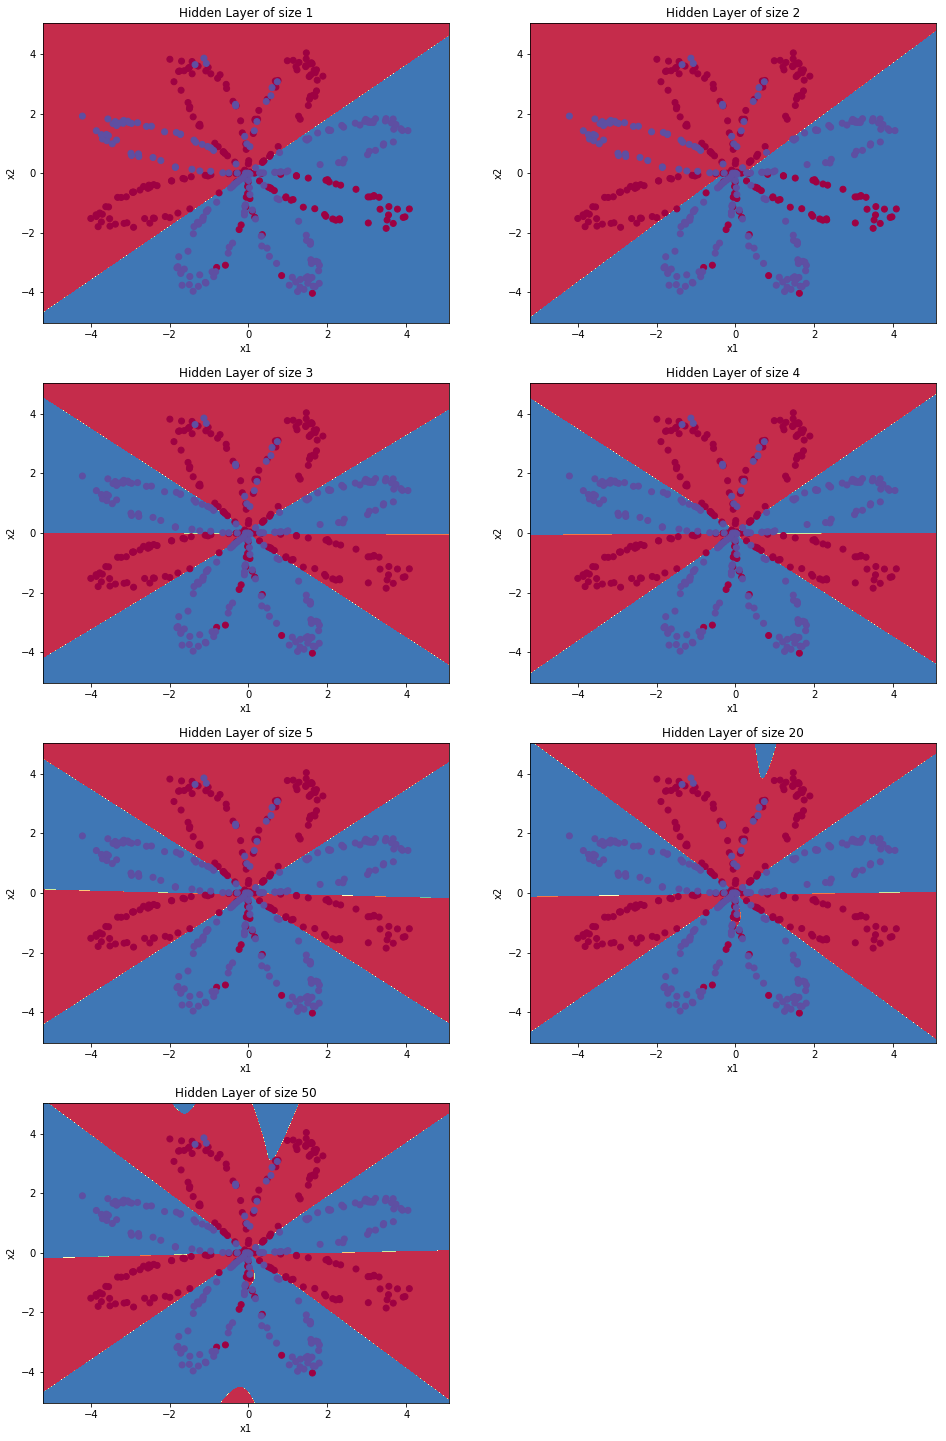

In [64]:
# 展示不同神经元个数的不同准确度。这段代码可以要运行几分钟。

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50] # 不同的神经元个数
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations=5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y.ravel())
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)
    print ("{}个隐藏层神经元时的准确度是: {} %".format(n_h, accuracy))